In [1]:
%matplotlib inline

%load_ext autoreload
%autoreload 2

from matplotlib.gridspec import GridSpec
import matplotlib.pyplot as plt
import matplotlib
from skimage.transform import resize
from imageio import imread, imwrite
import pandas as pd
import glob
import pickle

from stn.conv_model import conv_model
from stn.conv_model import conv_model_no_color_adjust
from sklearn.utils import resample
from lib.utils import load_gtsrb
from keras.metrics import sparse_categorical_accuracy

from parameters import *
from small_net import *

Using TensorFlow backend.


In [2]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
signnames = pd.read_csv(DATA_DIR + 'signnames.csv')
X_train, y_train, X_val, y_val, X_test, y_test = load_gtsrb()

In [4]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
from keras.backend.tensorflow_backend import set_session
set_session(sess)

In [5]:
model = conv_model_no_color_adjust()
# model = conv_model()
model.load_weights("./keras_weights/stn_v5.hdf5")

get_stn_output = K.function([model.layers[0].input, K.learning_phase()],
                            [model.layers[1].output])
stn_weight = model.layers[1].get_weights()

In [6]:
def get_patch(X, pos):
    """
    Crop all samples in <X> to make a set of patches <X_cropped>
    at the same position <pos>
    """
    
    top, bot, left, right = pos
    X_cropped = np.zeros((X.shape[0], bot - top, right - left, X.shape[3]))
    for i, x in enumerate(X):
        X_cropped[i] = np.copy(x[top:bot, left:right, :])
    return X_cropped

# Define cropping positions
pos_2 = (7, 23, 5, 17)
pos_0 = (7, 24, 15, 27) # Good for class 0 - 5
pos_3 = (7, 24, 6, 17)

pos_S = (7, 24, 0, 11)
pos_T = (7, 23, 8, 17)
pos_O = (6, 23, 13, 24)
pos_P = (6, 23, 22, 32)

pos_y11 = (11, 27, 9, 21)

In [7]:
X_S = X_train[np.where(y_train == 14)]
X_stn = get_stn_output([X_S, 0])[0]*0.5 + 0.5
S = get_patch(X_stn, pos_S)
O = get_patch(X_stn, pos_O)

In [8]:
X_stop = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_stop, 0])[0]*0.5 + 0.5
S_test = get_patch(X_stn, pos_S)
O_test = get_patch(X_stn, pos_O)

## 1. Distance to mean in RGB

Mean of RGB image


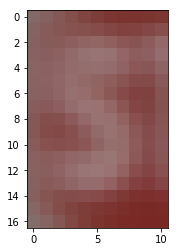

Sample closest to the mean


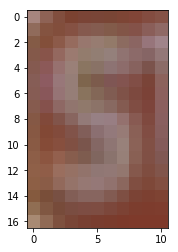

L2 dist from mean: 1.0824


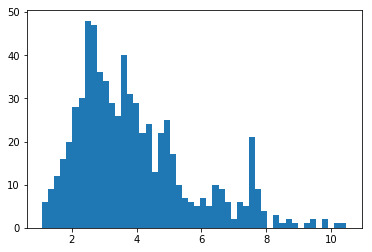

In [10]:
# Try transformaing 'S'
print("Mean of RGB image")
mean = np.mean(S, axis=0)
plt.imshow(mean)
plt.show()
    
# Sample that's closest to the mean
dist = np.sqrt(np.sum(np.square(S - mean).reshape(S.shape[0], -1), axis=1))
ind_center = np.argmin(dist)
print("Sample closest to the mean")
x_mean = S[ind_center]
plt.imshow(x_mean)
plt.show()
print("L2 dist from mean: {:.4f}".format(dist[ind_center]))
plt.hist(dist, bins=50)
plt.show()

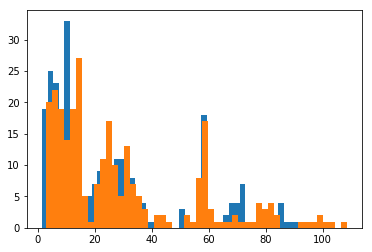

In [13]:
dist_S = np.sum((S_test - mean)**2, (1, 2, 3))
dist_O = np.sum((O_test - mean)**2, (1, 2, 3))
plt.hist(dist_S, bins=50)
plt.hist(dist_O, bins=50)
plt.show()

## 2. Distance to mean in HSV

https://en.wikipedia.org/wiki/Mean_of_circular_quantities

In [12]:
def hsv_dist(image_a, image_b):
    
    out = np.zeros_like(image_a)
    dist1 = np.square(image_a - image_b)
    out[:, :, 1:] = dist1[:, :, 1:]
    
    # Hue distance
    dist2 = np.square(image_a + 1 - image_b)
    dist3 = np.square(image_a - image_b - 1)
    dist = np.minimum(dist1, dist2)
    out[:, :, 0] = np.minimum(dist, dist3)[:, :, 0]
    return out

def hsv_mean(images):
    
    from scipy.stats import circmean
    out = np.zeros_like(images[0])
    out[:, :, 1:] = np.mean(images[:, :, :, 1:], axis=0)
    out[:, :, 0] = circmean(images[:, :, :, 0], high=1, low=0, axis=0)
    return out

def hsv_std(images):
    
    from scipy.stats import circstd
    out = np.zeros_like(images[0])
    out[:, :, 1:] = np.std(images[:, :, :, 1:], axis=0)
    out[:, :, 0] = circstd(images[:, :, :, 0], high=1, low=0, axis=0)
    return out

Mean of HSV image


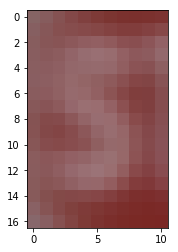

In [56]:
print("Mean of HSV image")
S_hsv = matplotlib.colors.rgb_to_hsv(S)
mean = hsv_mean(S_hsv)
plt.imshow(matplotlib.colors.hsv_to_rgb(mean))
plt.show()

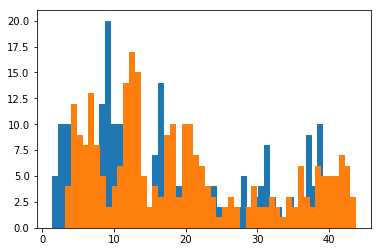

In [57]:
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_S = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_O = np.sum(dist, (1, 2, 3))
plt.hist(dist_S, bins=50)
plt.hist(dist_O, bins=50)
plt.show()

## 3. Distance to mean in Hue

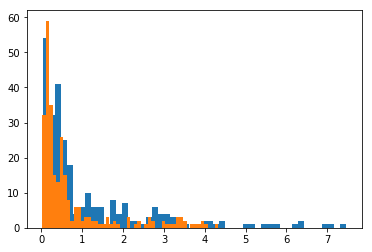

In [58]:
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_S = np.sum(dist[:, :, :, 0], (1, 2))
dist = np.array([hsv_dist(x, mean) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_O = np.sum(dist[:, :, :, 0], (1, 2))
plt.hist(dist_S, bins=50)
plt.hist(dist_O, bins=50)
plt.show()

## 4. NN to mean

Mean of HSV image


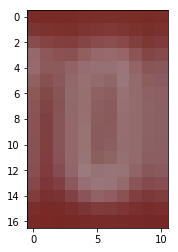

In [34]:
print("Mean of HSV image")
O_hsv = matplotlib.colors.rgb_to_hsv(O)
mean = hsv_mean(O_hsv)
plt.imshow(matplotlib.colors.hsv_to_rgb(mean))
plt.show()

In [59]:
S_hsv = matplotlib.colors.rgb_to_hsv(S)
mean_S = hsv_mean(S_hsv)
O_hsv = matplotlib.colors.rgb_to_hsv(O)
mean_O = hsv_mean(O_hsv)

dist = np.array([hsv_dist(x, mean_S) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_SS = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O) for x in matplotlib.colors.rgb_to_hsv(S_test)])
dist_SO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_OO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_S) for x in matplotlib.colors.rgb_to_hsv(O_test)])
dist_OS = np.sum(dist, (1, 2, 3))

print(np.sum(dist_SS < dist_SO))
print(np.sum(dist_OO < dist_OS))

269
264


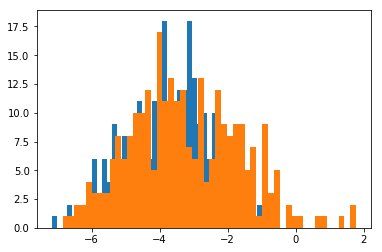

In [63]:
diff = dist_SS - dist_SO
plt.hist(diff, bins=50)
diff = dist_OO - dist_OS
plt.hist(diff, bins=50)
plt.show()

## 5. NN to mean with HSV and binarization

8-bit info

269
264


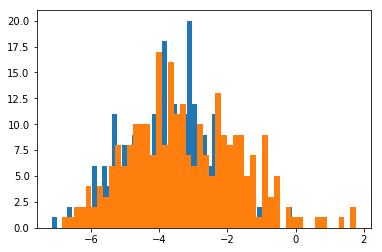

In [65]:
S_bin = (matplotlib.colors.rgb_to_hsv(S_test) * 255).astype(np.int32) / 255.
O_bin = (matplotlib.colors.rgb_to_hsv(O_test) * 255).astype(np.int32) / 255.
mean_S_bin = (mean_S * 255).astype(np.int32) / 255.
mean_O_bin = (mean_O * 255).astype(np.int32) / 255.

dist = np.array([hsv_dist(x, mean_S_bin) for x in S_bin])
dist_SS = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in S_bin])
dist_SO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in O_bin])
dist_OO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_S_bin) for x in O_bin])
dist_OS = np.sum(dist, (1, 2, 3))

print(np.sum(dist_SS < dist_SO))
print(np.sum(dist_OO < dist_OS))

diff = dist_SS - dist_SO
plt.hist(diff, bins=50)
diff = dist_OO - dist_OS
plt.hist(diff, bins=50)
plt.show()

Binary

129
228


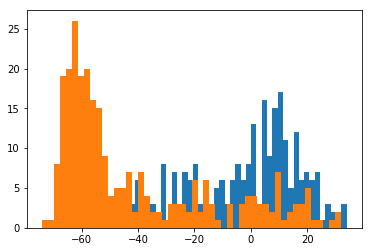

In [66]:
S_bin = (matplotlib.colors.rgb_to_hsv(S_test) > 0.5).astype(np.float32)
O_bin = (matplotlib.colors.rgb_to_hsv(O_test) > 0.5).astype(np.float32)
mean_S_bin = (mean_S > 0.5).astype(np.float32)
mean_O_bin = (mean_O > 0.5).astype(np.float32)

dist = np.array([hsv_dist(x, mean_S_bin) for x in S_bin])
dist_SS = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in S_bin])
dist_SO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_O_bin) for x in O_bin])
dist_OO = np.sum(dist, (1, 2, 3))
dist = np.array([hsv_dist(x, mean_S_bin) for x in O_bin])
dist_OS = np.sum(dist, (1, 2, 3))

print(np.sum(dist_SS < dist_SO))
print(np.sum(dist_OO < dist_OS))

diff = dist_SS - dist_SO
plt.hist(diff, bins=50)
diff = dist_OO - dist_OS
plt.hist(diff, bins=50)
plt.show()

## Experiment with more features

In [10]:
from skimage.transform import resize

size = (16, 16)
pos = [pos_S, pos_T, pos_O, pos_P]

X_stop = X_train[np.where(y_train == 14)]
X_stn = get_stn_output([X_stop, 0])[0]*0.5 + 0.5
feat_train = [np.array([resize(x, size, order=1) for x in get_patch(X_stn, p)]) for p in pos]
X_stop = X_test[np.where(y_test == 14)]
X_stn = get_stn_output([X_stop, 0])[0]*0.5 + 0.5
feat_test = [np.array([resize(x, size, order=1) for x in get_patch(X_stn, p)]) for p in pos]

feat_train = [matplotlib.colors.rgb_to_hsv(f) for f in feat_train]
feat_test = [matplotlib.colors.rgb_to_hsv(f) for f in feat_test]

/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/usr/local/lib/python3.5/dist-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


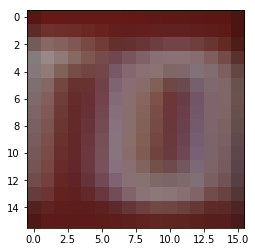

In [115]:
plt.imshow(matplotlib.colors.hsv_to_rgb(feat_train[2][80]))

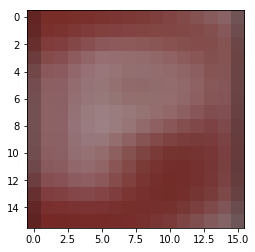

In [116]:
mean_hsv = [hsv_mean(f) for f in feat_train]

plt.imshow(matplotlib.colors.hsv_to_rgb(mean_hsv[3]))

In [110]:
mean_hsv = [(mean * 255).astype(np.int32) / 255. for mean in mean_hsv]
feat_train = [(f * 255).astype(np.int32) / 255. for f in feat_train]
feat_test = [(f * 255).astype(np.int32) / 255. for f in feat_test]

In [117]:
dist_all = []
for feat in feat_train:
    dist_feat = []
    for x in feat:
        dist = np.array([np.sum(hsv_dist(x, mean)) for mean in mean_hsv])
        dist_feat.append(dist)
    dist_all.append(np.array(dist_feat))
    
for feat in range(4):
    f_close = np.argmin(dist_all[feat], axis=1)
#     print(np.sum(f_close == feat))
    print(np.sum(f_close == 0), np.sum(f_close == 1), np.sum(f_close == 2), np.sum(f_close == 3))

580 110 0 0
36 572 80 2
6 59 624 1
1 19 13 657


In [118]:
dist_all = []
for feat in feat_test:
    dist_feat = []
    for x in feat:
        dist = np.array([np.sum(hsv_dist(x, mean)) for mean in mean_hsv])
        dist_feat.append(dist)
    dist_all.append(np.array(dist_feat))

for feat in range(4):
    f_close = np.argmin(dist_all[feat], axis=1)
#     print(np.sum(f_close == feat))
    print(np.sum(f_close == 0), np.sum(f_close == 1), np.sum(f_close == 2), np.sum(f_close == 3))

235 35 0 0
31 207 26 6
6 41 219 4
12 5 2 251


## 6. Hue Threshold

Manually set

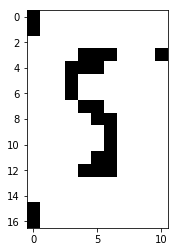

In [32]:
thres = [0, 0.65, 0.5]
width = [0.1, 1 - thres[1], 1 - thres[2]]

S_hsv = matplotlib.colors.rgb_to_hsv(S)
mean_S = hsv_mean(S_hsv)
thres_hsv = np.zeros_like(mean_S) + thres
dist = hsv_dist(mean_S, thres_hsv)
diff = (np.zeros_like(mean_S) + width)**2
out = np.sum(dist < diff, axis=2) // 3

plt.imshow(out, cmap='gray')
plt.show()

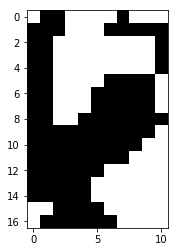

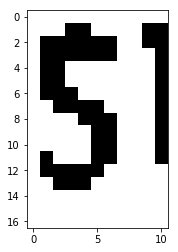

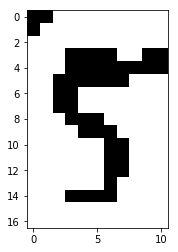

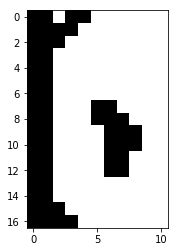

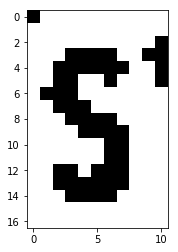

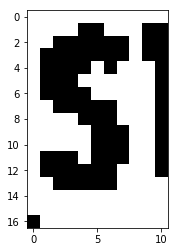

In [33]:
for i in [0, 50, 100, 150, 200, 250]:
    dist = np.sqrt(hsv_dist(S_hsv[i], thres_hsv))
    diff = np.zeros_like(S_hsv[i]) + width
    out = np.sum(dist < diff, axis=2) // 3
    plt.imshow(out, cmap='gray')
    plt.show()

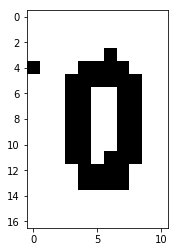

In [34]:
O_hsv = matplotlib.colors.rgb_to_hsv(O)
mean_O = hsv_mean(O_hsv)
thres_hsv = np.zeros_like(mean_O) + thres
dist = hsv_dist(mean_O, thres_hsv)
diff = (np.zeros_like(mean_O) + width)**2
out = np.sum(dist < diff, axis=2) // 3

plt.imshow(out, cmap='gray')
plt.show()

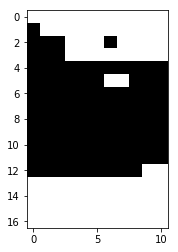

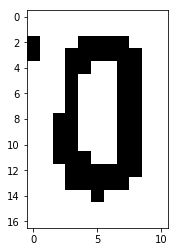

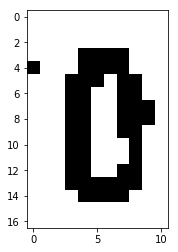

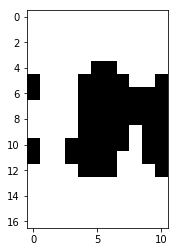

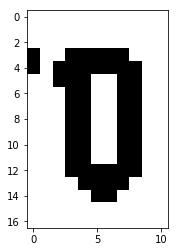

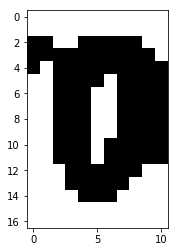

In [35]:
for i in [0, 50, 100, 150, 200, 250]:
    dist = np.sqrt(hsv_dist(O_hsv[i], thres_hsv))
    diff = np.zeros_like(O_hsv[i]) + width
    out = np.sum(dist < diff, axis=2) // 3
    plt.imshow(out, cmap='gray')
    plt.show()

Try to adjust mean first in RGB

In [15]:
mean = np.mean(S)
S_center = np.array([x - np.mean(x) + mean for x in S])

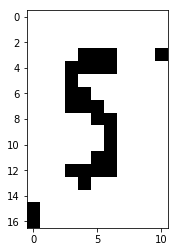

In [27]:
thres = [0, 0.65, 0.5]
width = [0.1, 1 - thres[1], 1 - thres[2]]

S_hsv = matplotlib.colors.rgb_to_hsv(S_center)
mean_S = hsv_mean(S_hsv)
thres_hsv = np.zeros_like(mean_S) + thres
dist = hsv_dist(mean_S, thres_hsv)
diff = (np.zeros_like(mean_S) + width)**2
out = np.sum(dist < diff, axis=2) // 3

plt.imshow(out, cmap='gray')
plt.show()

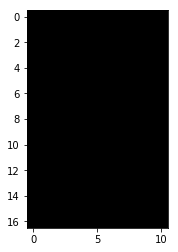

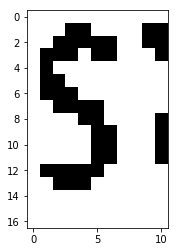

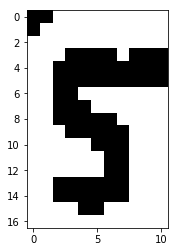

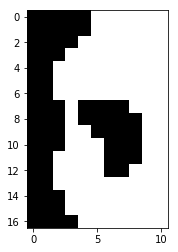

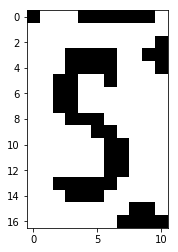

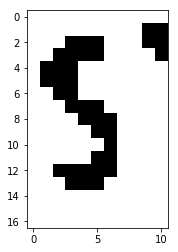

In [28]:
for i in [0, 50, 100, 150, 200, 250]:
    dist = np.sqrt(hsv_dist(S_hsv[i], thres_hsv))
    diff = np.zeros_like(S_hsv[i]) + width
    out = np.sum(dist < diff, axis=2) // 3
    plt.imshow(out, cmap='gray')
    plt.show()

## Neural Network Approach  

Use neural network confidence score as output to another classifier which takes N real numbers (N is number of features per class) and outputs a final confidence for how likely the proposed label is correct. Probably need some confidence score calibration.

Problem:  
- how do we label "bad samples" e.g. not really visible S on a stop sign?

## Nearest Neighbor

We evaluate nearest neighbors of S by measuring distance from S to S and from non-S to S. For non-S, we pick O as a representative as it should be very close to S (use O as a bound).  

Problem: how do we justify if it's robust?  
In other words, just because it works for distinguishing some features like S from O, it doesn't prvide any guarantee of its robustness or how "good" it is to other digits.

In [9]:
dist_SS = np.zeros([len(S_test), len(S)])
dist_OS = np.zeros([len(O_test), len(S)])

for i, s in enumerate(S_test):
    dist_SS[i] = np.sum((S - s)**2, axis=(1, 2, 3))
for i, o in enumerate(O_test):
    dist_OS[i] = np.sum((S - o)**2, axis=(1, 2, 3))

Average


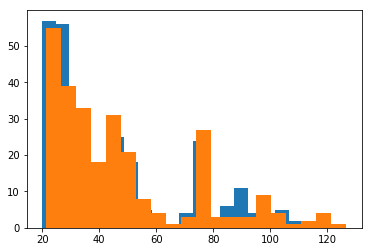

Minimum


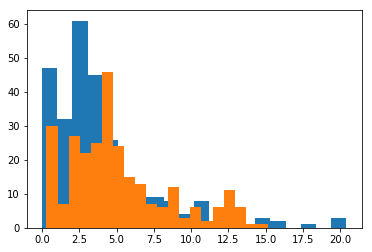

Median


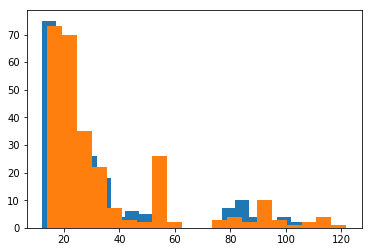

In [29]:
print("Average")
plt.hist(np.mean(dist_SS, axis=1), bins=20)
plt.hist(np.mean(dist_OS, axis=1), bins=20)
plt.show()

print("Minimum")
plt.hist(np.min(dist_SS, axis=1), bins=20)
plt.hist(np.min(dist_OS, axis=1), bins=20)
plt.show()

print("Median")
plt.hist(np.median(dist_SS, axis=1), bins=20)
plt.hist(np.median(dist_OS, axis=1), bins=20)
plt.show()

Average of smallest k


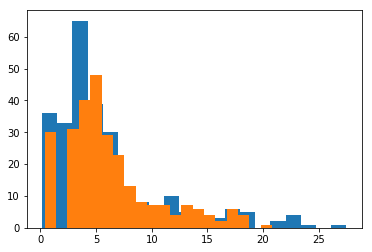

In [46]:
print("Average of smallest k")
plt.hist(np.mean(np.sort(dist_SS)[:, :20], axis=1), bins=20)
plt.hist(np.mean(np.sort(dist_OS)[:, :20], axis=1), bins=20)
plt.show()

Looking at distance distribution simply does not work. This is different from normal kNN.  
kNN, in a way, considers "relative distance."  

We cannot implement kNN naively because we want to determine not only which feature an input is closest to but also how close. But unfortunately, distance (l2) is a meaningless metric. Eg. X is closer to S than to O, but that does not mean X is S.

Arguably, we can still implement something more like kNN, but now we need to combine all possible features so we can say with more confident. BUT then again l2 is not a good metric so it's pointless.

## Test RGB2HSV

In [85]:
from stn.rgb2hsv import RGB2HSV

inpt = keras.layers.Input(shape=(32, 32, 3))
u = RGB2HSV(output_dim=(32, 32, 3))(inpt)
model = keras.models.Model(inputs=inpt, outputs=u)

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = model(x)

In [86]:
feed_dict = {x: X_train[:100]}
# feed_dict = {x: np.ones([10, 32, 32, 3])}
X_hsv = sess.run(y, feed_dict=feed_dict)

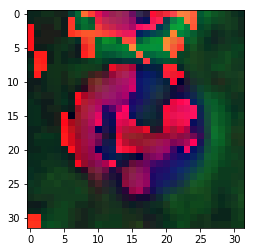

In [87]:
plt.imshow(X_hsv[0])

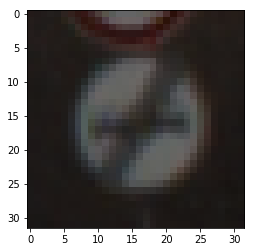

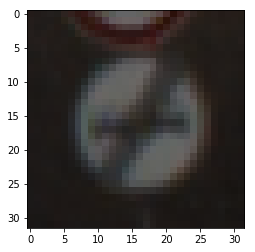

In [88]:
i = 9
plt.imshow(matplotlib.colors.hsv_to_rgb(X_hsv[i]))
plt.show()
plt.imshow(X_train[i])

In [17]:
np.sum(np.abs(matplotlib.colors.hsv_to_rgb(X_hsv) - X_train[:100]))

0.0010577217

## Test HueThres

In [112]:
import skimage

In [168]:
from stn.rgb2hsv import RGB2HSV
from stn.thres import HSVThres

inpt = keras.layers.Input(shape=(32, 32, 3))
u = RGB2HSV(output_dim=(32, 32, 3))(inpt)
u = HSVThres([[0.95, 0.05], [0.3, 1.5], [0.2, 1.5]], steep=200, output_dim=(32, 32))(u)
model = keras.models.Model(inputs=inpt, outputs=u)

x = tf.placeholder(tf.float32, [None, 32, 32, 3])
y = model(x)

In [169]:
ind = np.random.randint(0, len(X_train), 10)
feed_dict = {x: X_train[ind]}
X_hsv1 = sess.run(y, feed_dict=feed_dict)
# feed_dict = {x: skimage.exposure.equalize_hist(X_train[ind])}
feed_dict = {x: np.array([skimage.exposure.equalize_adapthist(X_train[i]) for i in ind])}
# feed_dict = {x: np.ones([10, 32, 32, 3])}
X_hsv2 = sess.run(y, feed_dict=feed_dict)

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


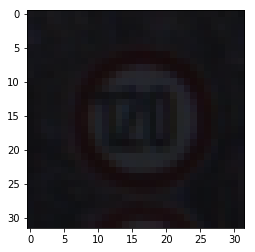

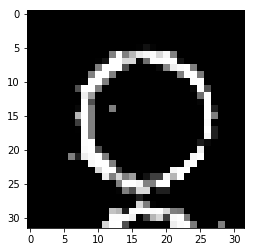

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


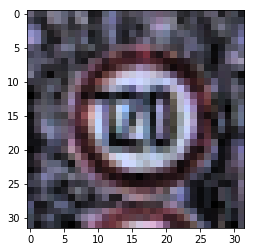

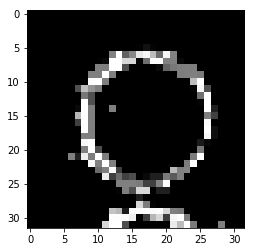

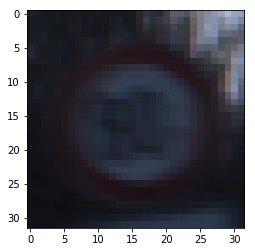

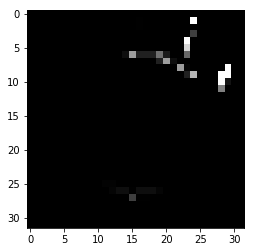

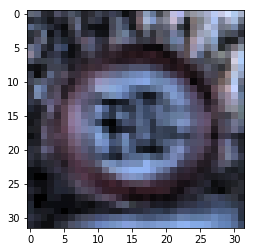

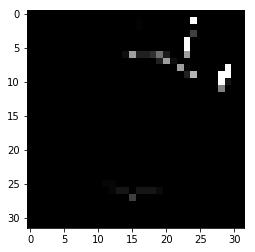

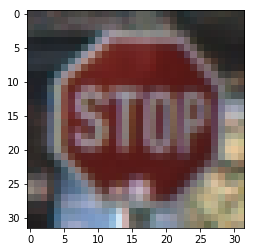

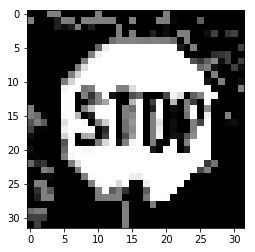

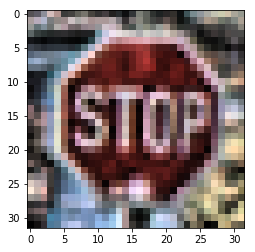

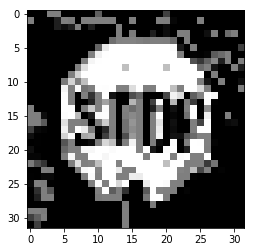

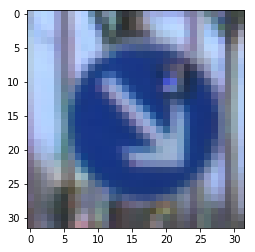

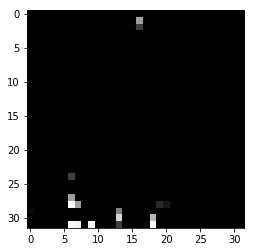

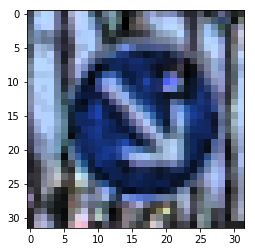

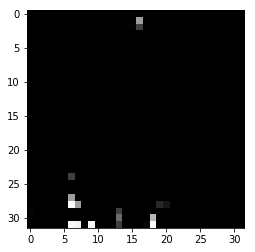

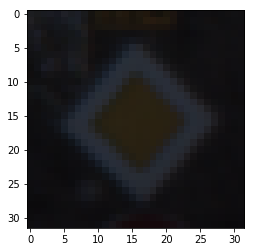

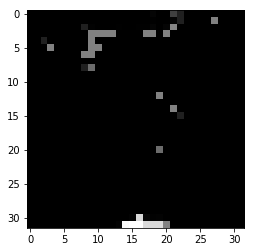

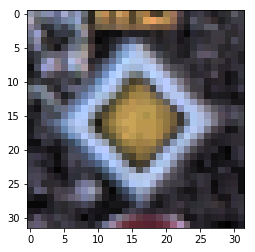

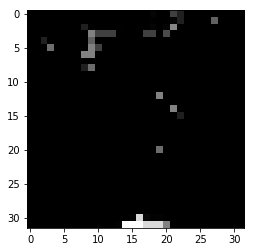

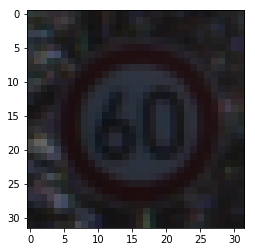

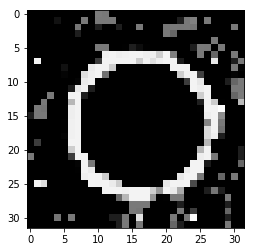

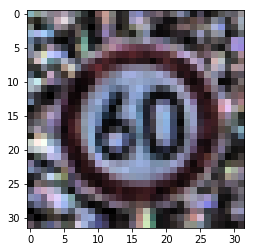

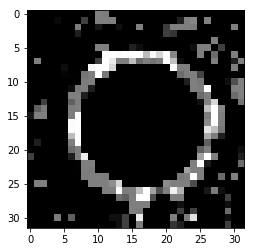

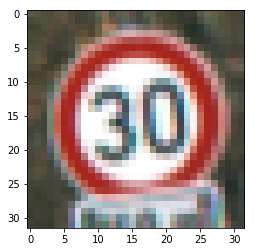

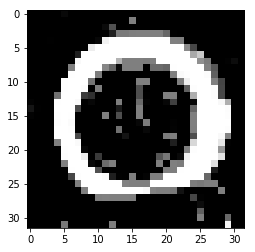

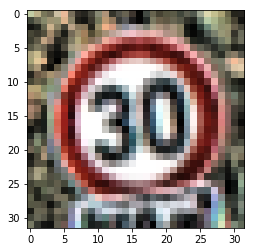

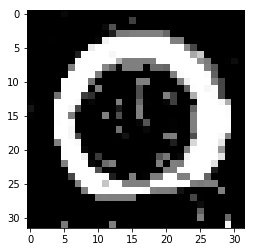

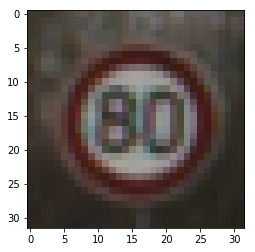

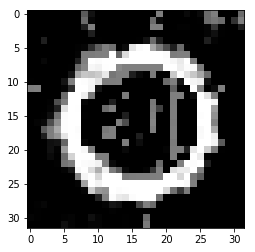

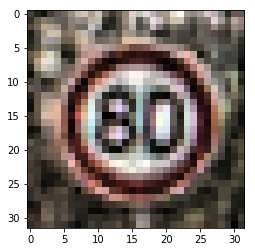

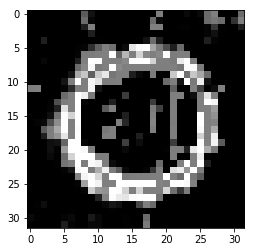

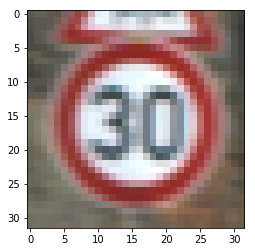

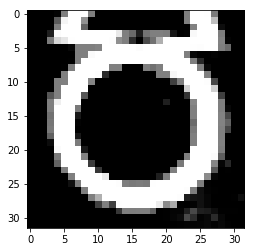

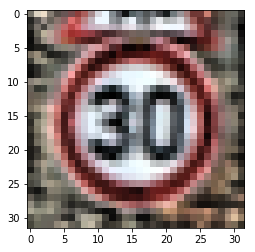

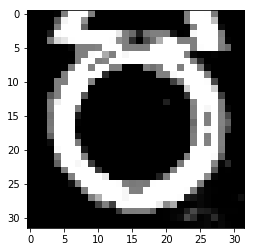

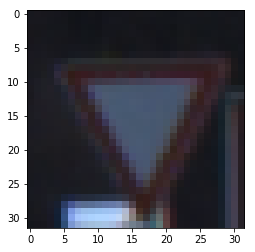

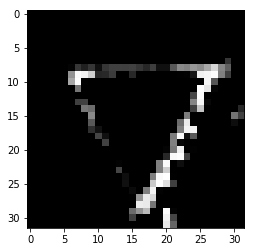

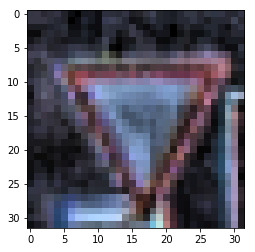

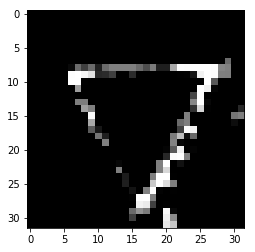

In [170]:
for i in range(10):
    plt.imshow(X_train[ind[i]])
    plt.show()
    plt.imshow(np.squeeze(X_hsv1[i]), cmap='gray')
    plt.show()
    plt.imshow(skimage.exposure.equalize_adapthist(X_train[ind[i]]))
    plt.show()
    plt.imshow(np.squeeze(X_hsv2[i]), cmap='gray')
    plt.show()

In [171]:
iind = np.where(y_train == 14)[0]
ind = np.random.choice(iind, 10)
feed_dict = {x: X_train[ind]}
X_hsv1 = sess.run(y, feed_dict=feed_dict)
# feed_dict = {x: skimage.exposure.equalize_hist(X_train[ind])}
feed_dict = {x: np.array([skimage.exposure.equalize_adapthist(X_train[i]) for i in ind])}
# feed_dict = {x: np.ones([10, 32, 32, 3])}
X_hsv2 = sess.run(y, feed_dict=feed_dict)

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


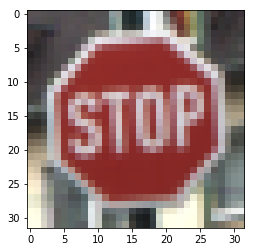

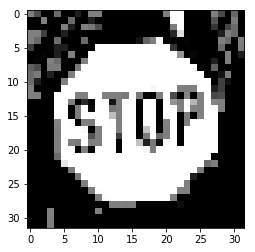

/usr/local/lib/python3.5/dist-packages/skimage/util/dtype.py:130: UserWarning: Possible precision loss when converting from float64 to uint16
  .format(dtypeobj_in, dtypeobj_out))


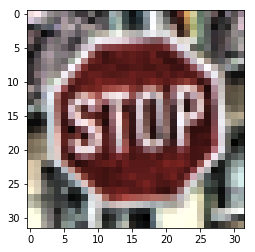

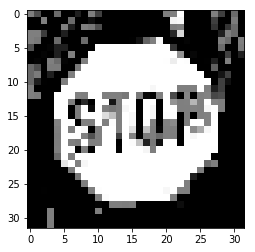

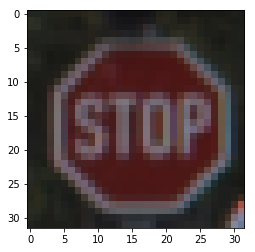

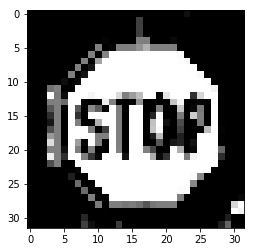

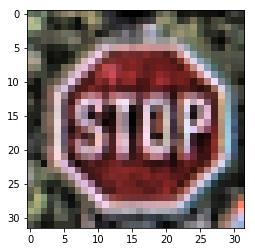

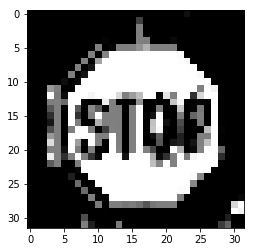

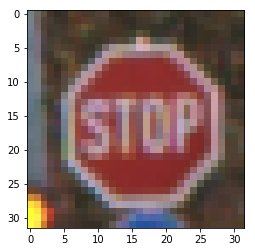

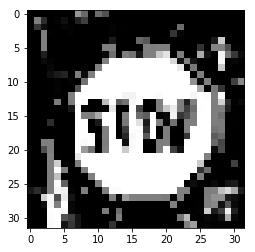

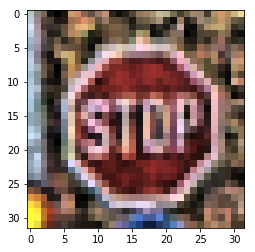

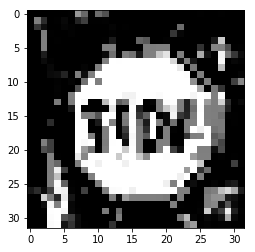

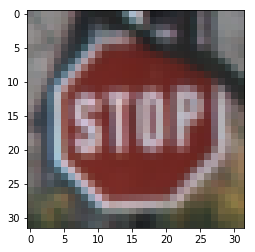

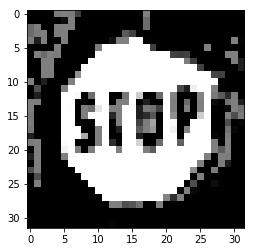

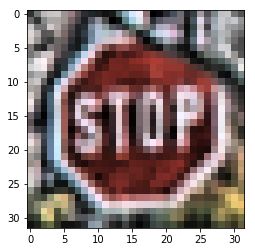

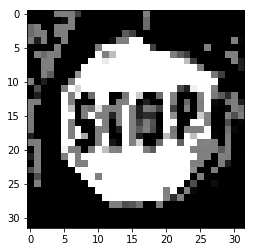

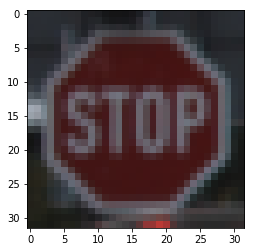

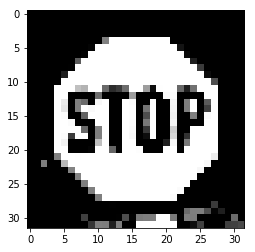

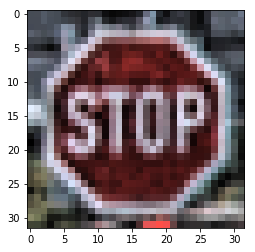

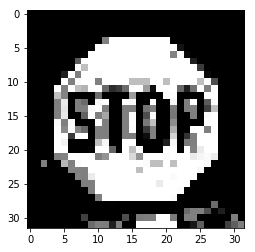

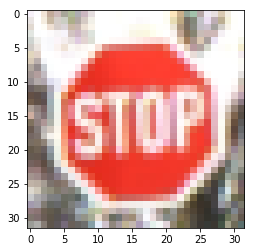

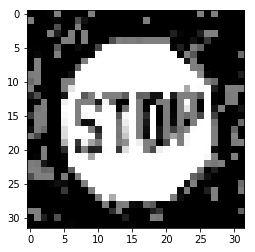

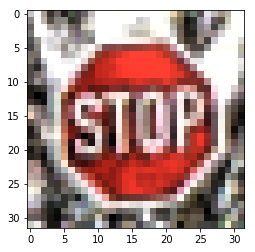

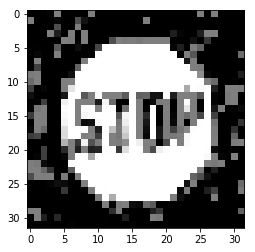

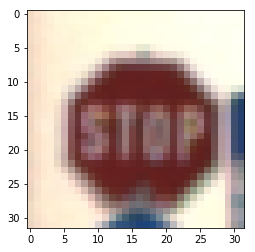

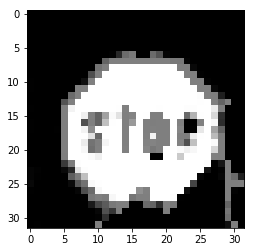

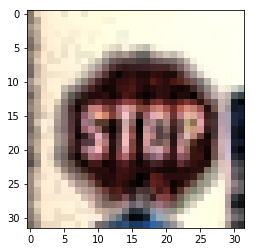

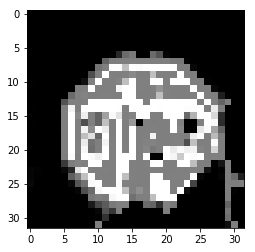

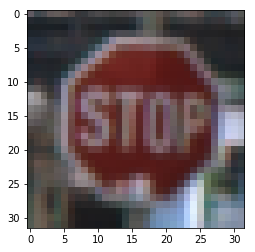

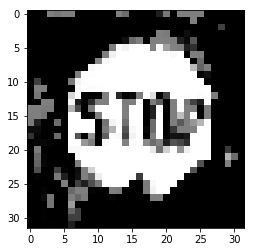

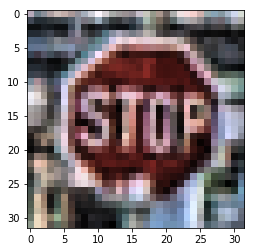

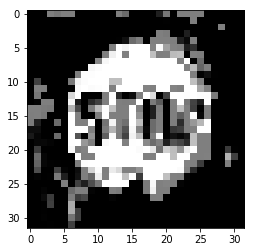

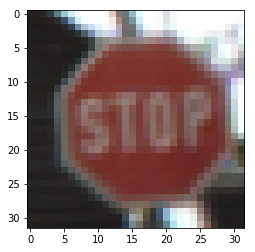

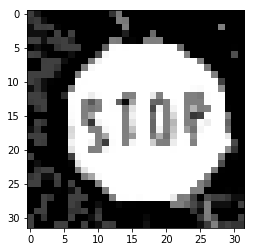

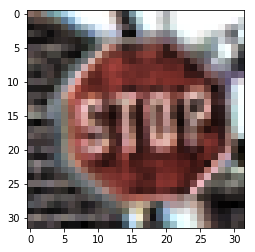

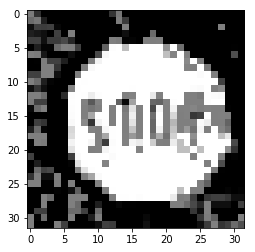

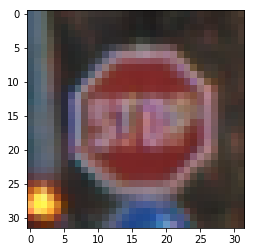

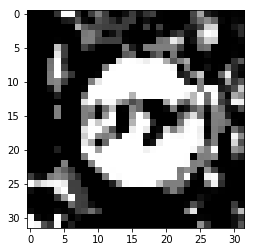

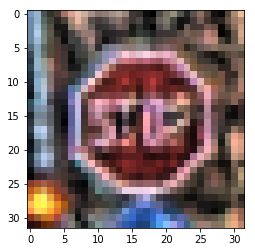

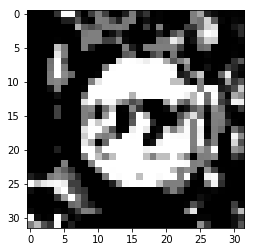

In [172]:
for i in range(10):
    plt.imshow(X_train[ind[i]])
    plt.show()
    plt.imshow(np.squeeze(X_hsv1[i]), cmap='gray')
    plt.show()
    plt.imshow(skimage.exposure.equalize_adapthist(X_train[ind[i]]))
    plt.show()
    plt.imshow(np.squeeze(X_hsv2[i]), cmap='gray')
    plt.show()

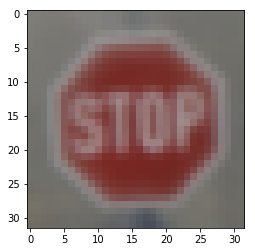

In [162]:
plt.imshow(np.mean(X_train[np.where(y_train == 14)[0]], 0))

In [151]:
matplotlib.colors.rgb_to_hsv(np.mean(X_train[np.where(y_train == 14)[0]], 0))[16, :, 0]

array([0.16145673, 0.16211106, 0.20109122, 0.45377076, 0.03131896,
       0.01255815, 0.9985877 , 0.9899118 , 0.99484164, 0.99972516,
       0.00650269, 0.00766171, 0.9979857 , 0.0030504 , 0.01335664,
       0.00330563, 0.98922884, 0.0119177 , 0.00332714, 0.99393666,
       0.00842968, 0.98896116, 0.9791457 , 0.00652096, 0.00398283,
       0.00598138, 0.00472303, 0.9934961 , 0.99024296, 0.07220583,
       0.12241281, 0.14739378], dtype=float32)

## Featnet HSV

In [173]:
X_train_bal, y_train_bal = gen_balance_data(X_train, y_train, [14], r=1)
y_train_bal = y_train_bal[:, np.newaxis]
X_val_bal, y_val_bal = gen_balance_data(X_val, y_val, [14], r=1)
y_val_bal = y_val_bal[:, np.newaxis]
X_test_bal, y_test_bal = gen_balance_data(X_test, y_test, [14], r=1)
y_test_bal = y_test_bal[:, np.newaxis]

y_test_stn = np.zeros([len(y_test), 1])
y_test_stn[np.where(y_test == 14)] = 1

In [50]:
from feat_net import FeatNet

featnet = FeatNet("featnet_hsv_v3", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_hsv_v3.h5",
                  load_model=True,
                  stn_weight=stn_weight)
# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, dataaug=True, n_epoch=30, batch_size=128)

In [52]:
featnet.eval_model(sess, (X_test_bal, y_test_bal))

(0.9879449838187703, -3.845270856530149)

In [53]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred < 3)
ind2 = y_test == 14
ind = np.where(np.logical_and(ind1, ind2))[0]
x = X_test[ind]
y = y_test[ind]

In [54]:
ind

array([  821,  6785,  9894, 10487, 11024])

In [55]:
print(pred[ind])

[[1.99721193]
 [2.84163308]
 [1.809515  ]
 [1.93533039]
 [1.99898946]]


In [56]:
featnet.predict_model(sess, X_test)[ind]

array([[1.99721193],
       [2.84163308],
       [1.809515  ],
       [1.93533039],
       [1.99898946]])

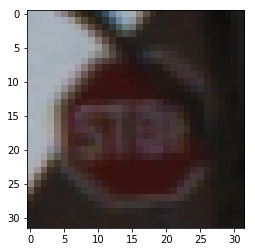

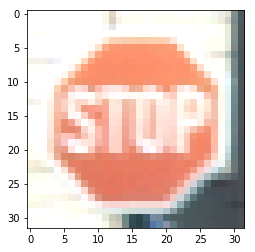

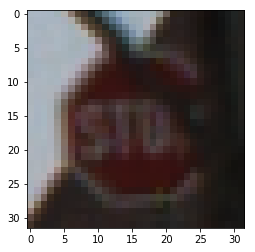

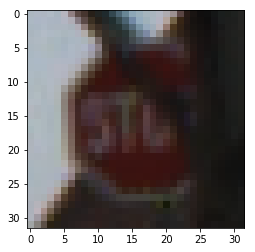

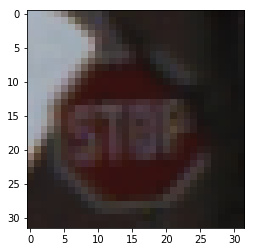

In [57]:
for i in x[:10]:
    plt.imshow(i)
    plt.show()

In [215]:
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import logging

n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

In [216]:
y_pred = model.predict(X_atk)
print("Clean accuracy: ", np.mean(np.argmax(y_pred, -1) == 1))
print("Clean acc by featnet: ", np.mean(featnet.predict_model(sess, X_atk) < 3))

Clean accuracy:  1.0
Clean acc by featnet:  1.0


In [60]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 10,
             'max_iterations': attack_iterations,
             'learning_rate': 0.01,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=4*.75, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-11-02 00:53:46,928 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
INFO:cleverhans:Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-11-02 00:53:50,021 cleverhans] Running CWL2 attack on instance 0 of 250
DEBUG:cleverhans:Running CWL2 attack on instance 0 of 250
[DEBUG 2018-11-02 00:53:50,369 cleverhans]   Binary search step 0 of 10
DEBUG:cleverhans:  Binary search step 0 of 10
[DEBUG 2018-11-02 00:53:54,063 cleverhans]     Iteration 0 of 500: loss=840 l2=0 loss1=0.00059
DEBUG:cleverhans:    Iteration 0 of 500: loss=840 l2=0 loss1=0.00059
[DEBUG 2018-11-02 00:54:02,259 cleverhans]     Iteration 50 of 500: loss=124 l2=12.8 loss1=2.98
DEBUG:cleverhans:    Iteration 50 of 500: loss=124 l2=12.8 loss1=2.98
[DEBUG 2018-11-02 00:54:10,767 cleverhans]     Iteration 100 of 500: loss=65 l2=15.1 loss1=3.38
DEBUG:cleverhans:    Iteration 100 of 500: loss=65 l2=15.1 loss1=3.38
[DEBUG 2018-11-02 00:54:19,472 cleverhans]     Iteration 150 of 500: loss=

[DEBUG 2018-11-02 00:59:05,404 cleverhans]     Iteration 400 of 500: loss=1.87e+03 l2=11.1 loss1=3.27
DEBUG:cleverhans:    Iteration 400 of 500: loss=1.87e+03 l2=11.1 loss1=3.27
[DEBUG 2018-11-02 00:59:13,624 cleverhans]     Iteration 450 of 500: loss=1.27e+03 l2=11.2 loss1=3.26
DEBUG:cleverhans:    Iteration 450 of 500: loss=1.27e+03 l2=11.2 loss1=3.26
[DEBUG 2018-11-02 00:59:21,211 cleverhans]   Successfully generated adversarial examples on 243 of 250 instances.
DEBUG:cleverhans:  Successfully generated adversarial examples on 243 of 250 instances.
[DEBUG 2018-11-02 00:59:21,213 cleverhans]    Mean successful distortion: 2.307
DEBUG:cleverhans:   Mean successful distortion: 2.307
[DEBUG 2018-11-02 00:59:21,214 cleverhans]   Binary search step 4 of 10
DEBUG:cleverhans:  Binary search step 4 of 10
[DEBUG 2018-11-02 00:59:21,355 cleverhans]     Iteration 0 of 500: loss=2.3e+05 l2=0 loss1=0.00059
DEBUG:cleverhans:    Iteration 0 of 500: loss=2.3e+05 l2=0 loss1=0.00059
[DEBUG 2018-11-02 

In [61]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:716: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-02 01:07:32,593 cleverhans] Constructing new graph for attack CustomPGD
INFO:cleverhans:Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [62]:
# (0.1, 0.01, 50)
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 3
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.684
Attack success on featnet:  0.352
Attack success on both:  0.240768
Mean successful l-2 dist:  3.67897
Mean successful l-inf dist:  0.10000002


In [69]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.9,
              'eps_iter': 0.05,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 4*.75, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:716: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-02 01:09:20,892 cleverhans] Constructing new graph for attack CustomPGD
INFO:cleverhans:Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [70]:
# (0.3, 0.01, 50)
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 3
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.996
Attack success on featnet:  0.896
Attack success on both:  0.892416
Mean successful l-2 dist:  20.632189
Mean successful l-inf dist:  0.89490986


## Featnet HSV + Thres

In [77]:
X_train_bal, y_train_bal = gen_balance_data(X_train, y_train, [14], r=1)
y_train_bal = y_train_bal[:, np.newaxis]
X_val_bal, y_val_bal = gen_balance_data(X_val, y_val, [14], r=1)
y_val_bal = y_val_bal[:, np.newaxis]
X_test_bal, y_test_bal = gen_balance_data(X_test, y_test, [14], r=1)
y_test_bal = y_test_bal[:, np.newaxis]

y_test_stn = np.zeros([len(y_test), 1])
y_test_stn[np.where(y_test == 14)] = 1

In [196]:
from feat_net import FeatNet

thres = {"thres_type": "diff",
         "thres_range": [[0.95, 0.05], [0.3, 1.2], [-0.2, 1.2]], 
         "thres_steep": 50
        }
featnet = FeatNet("featnet_thres_v13", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres=thres,
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_thres_v13.h5",
                  load_model=False,
                  stn_weight=stn_weight)
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, dataaug=True, n_epoch=10, batch_size=128, thres=0.75)

============= EPOCH: 0 =============
STEP: 0 	Loss: 0.0842
STEP: 50 	Loss: -0.5243
STEP: 100 	Loss: -0.5745
STEP: 150 	Loss: -0.9515
STEP: 200 	Loss: -1.0074
STEP: 250 	Loss: -1.1207
STEP: 300 	Loss: -0.9687
STEP: 350 	Loss: -1.1877
STEP: 400 	Loss: -1.3314
STEP: 450 	Loss: -1.2506
STEP: 500 	Loss: -1.3922
Train Acc|Loss:	0.9836|-1.4157
Val Acc|Loss:	0.9818|-1.4062
============= EPOCH: 1 =============
STEP: 0 	Loss: -1.3053
STEP: 50 	Loss: -1.2660
STEP: 100 	Loss: -1.4250
STEP: 150 	Loss: -1.4995
STEP: 200 	Loss: -1.3338
STEP: 250 	Loss: -1.6279
STEP: 300 	Loss: -1.5685
STEP: 350 	Loss: -1.7410
STEP: 400 	Loss: -1.4822
STEP: 450 	Loss: -1.4867
STEP: 500 	Loss: -1.6007
Train Acc|Loss:	0.9842|-1.6665
Val Acc|Loss:	0.9817|-1.6573
============= EPOCH: 2 =============
STEP: 0 	Loss: -1.5360
STEP: 50 	Loss: -1.5577
STEP: 100 	Loss: -1.6075
STEP: 150 	Loss: -1.4177
STEP: 200 	Loss: -1.2775
STEP: 250 	Loss: -1.7680
STEP: 300 	Loss: -1.9341
STEP: 350 	Loss: -1.6596
STEP: 400 	Loss: -1.9593
STEP

KeyboardInterrupt: 

In [197]:
get_output = K.function([featnet.model.layers[0].input],
                        [featnet.model.layers[5].output])
get_stn = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[3].output])
get_hsv = K.function([featnet.model.layers[0].input],
                     [featnet.model.layers[4].output])

In [198]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=0.75)

(0.9871359223300971, -1.9253124713319019)

In [199]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred < 3)
ind2 = y_test == 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
Y = y_test[ind]

In [200]:
for i in X[:10]:
    plt.imshow(i)
    plt.show()

In [133]:
x = X[0][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

IndexError: index 0 is out of bounds for axis 0 with size 0

In [211]:
X = X_train[np.where(y_train == 14)[0]]

[array([[0.9613684]], dtype=float32), array([[0.97340447]], dtype=float32), array([[0.99175346]], dtype=float32), array([[0.9926306]], dtype=float32)]
[array([[3.2142873]], dtype=float32), array([[3.6000576]], dtype=float32), array([[4.7896767]], dtype=float32), array([[4.903022]], dtype=float32)]


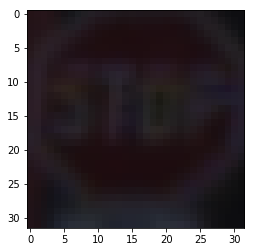

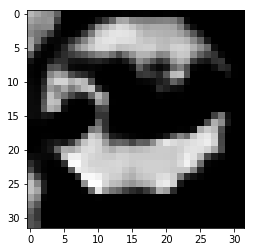

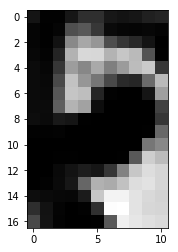

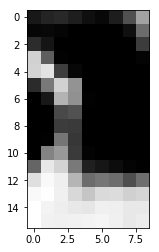

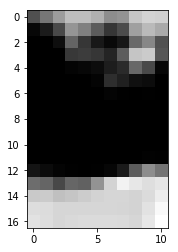

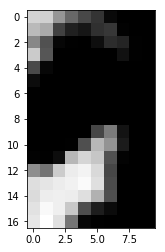

In [239]:
i = np.random.choice(len(X))

# x = X[i][np.newaxis]
x = X_train[np.where(y_train == 14)[0]][0][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [201]:
pred = featnet.predict_model(sess, X_test)
ind1 = np.squeeze(pred > 3)
ind2 = y_test != 14
ind = np.where(np.logical_and(ind1, ind2))[0]
X = X_test[ind]
y = y_test[ind]

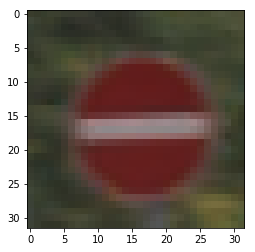

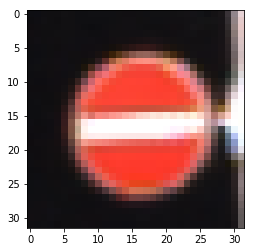

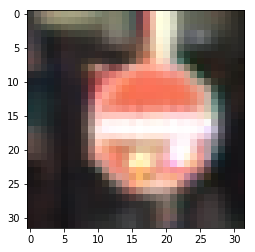

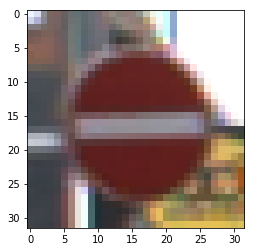

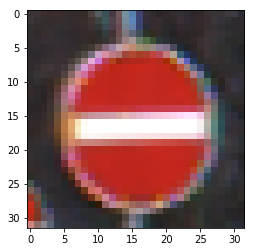

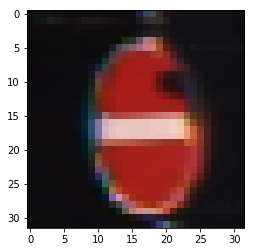

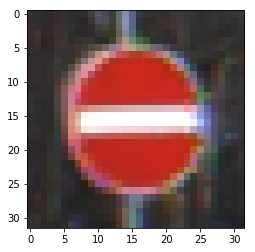

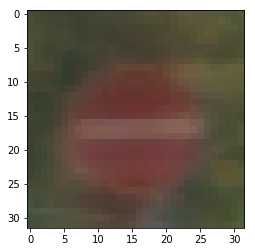

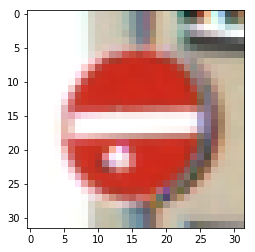

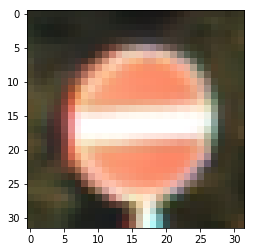

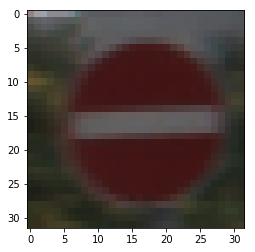

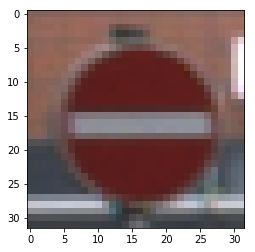

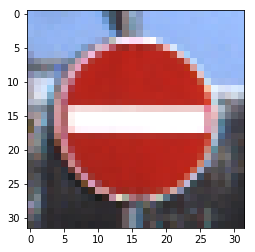

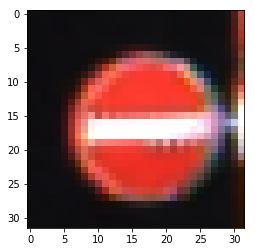

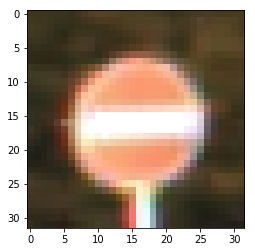

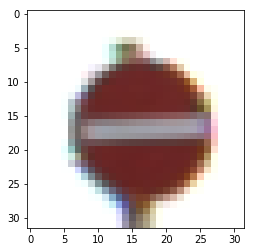

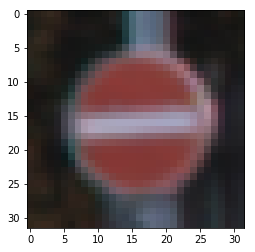

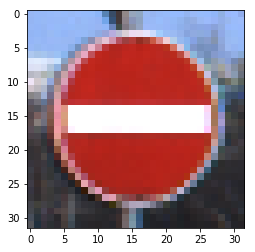

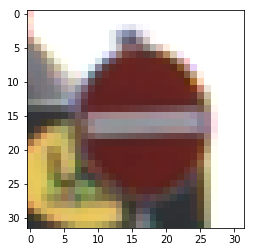

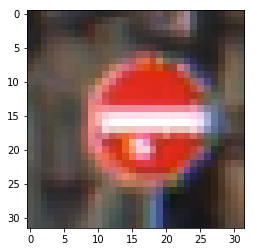

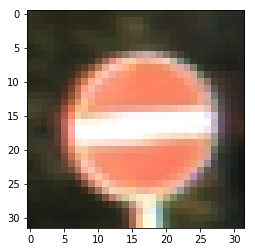

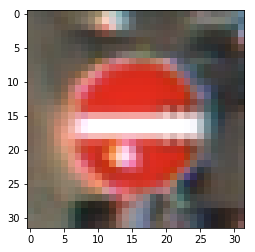

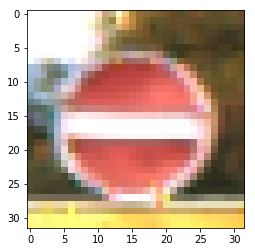

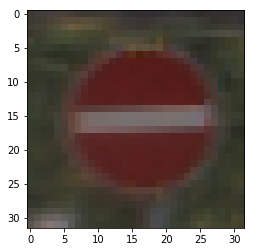

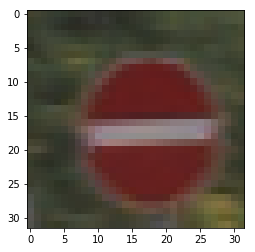

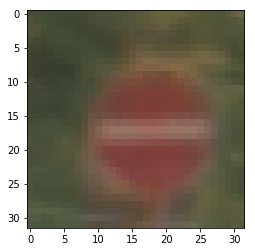

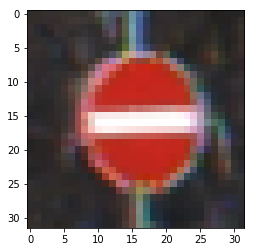

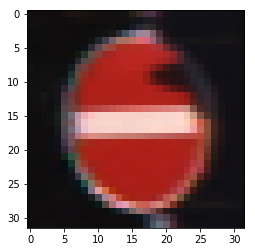

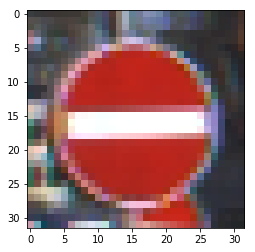

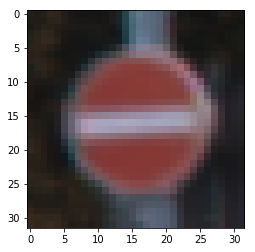

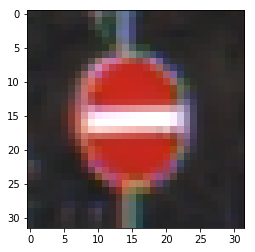

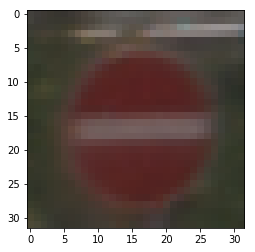

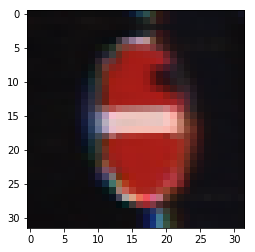

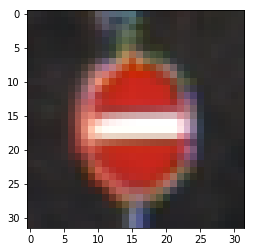

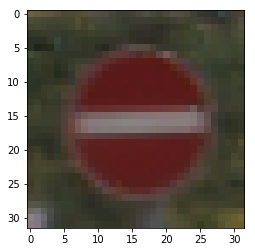

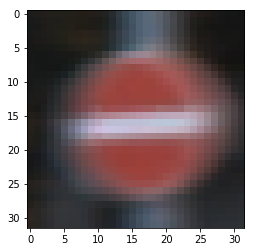

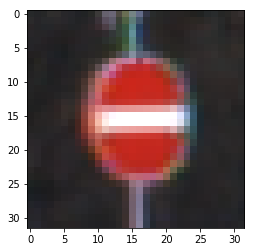

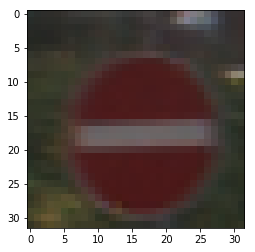

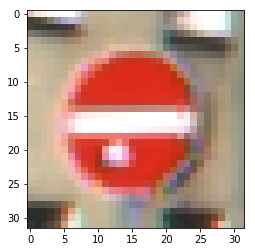

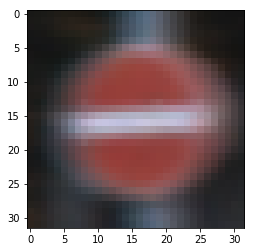

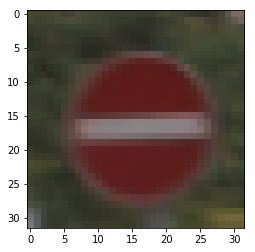

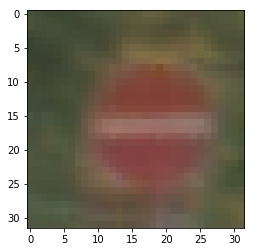

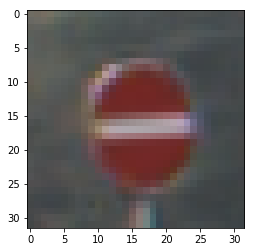

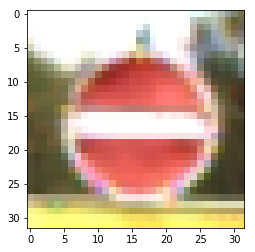

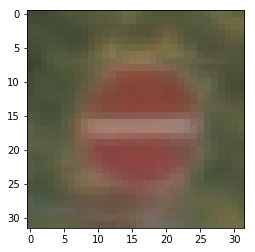

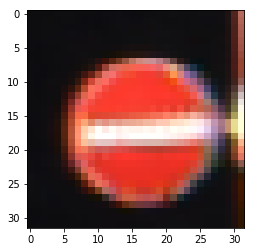

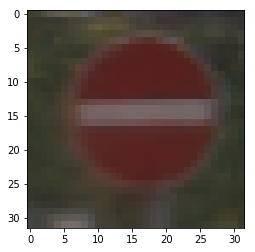

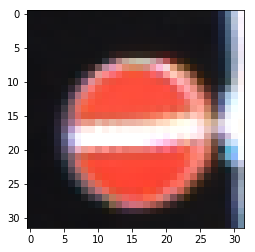

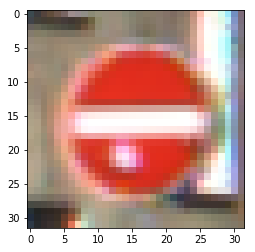

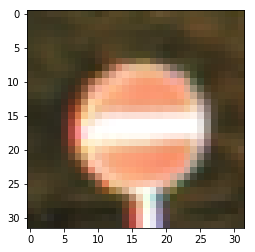

In [203]:
for i in X[:50]:
    plt.imshow(i)
    plt.show()

[array([[0.99747187]], dtype=float32), array([[0.99990964]], dtype=float32), array([[0.9999491]], dtype=float32), array([[0.99956185]], dtype=float32)]
[array([[5.9777427]], dtype=float32), array([[9.311594]], dtype=float32), array([[9.885021]], dtype=float32), array([[7.7326403]], dtype=float32)]


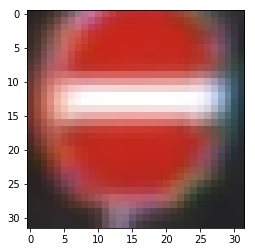

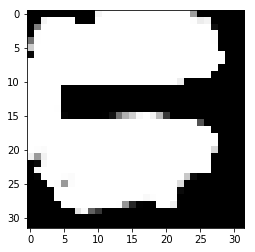

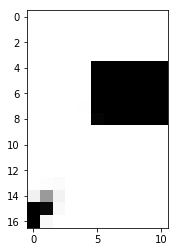

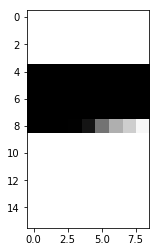

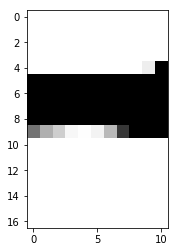

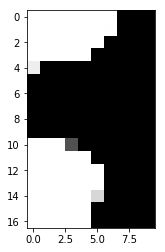

In [185]:
i = np.random.choice(len(X))

x = X[i][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [186]:
from cleverhans.attacks import FastGradientMethod, CarliniWagnerL2
from cleverhans.utils import set_log_level
from cleverhans.utils_keras import KerasModelWrapper
from cleverhans.utils_tf import model_eval
import logging

n_attack = 250
ind_1 = np.where(y_test == 1)[0]
X_atk = X_test[ind_1][:n_attack]

y_target = np.zeros((n_attack, )) + 14
y_target = to_categorical(y_target, 43)

In [113]:
keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

# CarliniWagner attack
from lib.custom_cw import CustomCarliniWagnerL2

attack_iterations = 500
cw_params = {'binary_search_steps': 3,
             'max_iterations': attack_iterations,
             'learning_rate': 0.01,
             'batch_size': n_attack,
             'initial_const': 10,
             'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
cw = CustomCarliniWagnerL2(wrap_clf, featnet, thres=3, sess=sess)
adv = cw.generate_np(X_atk, **cw_params)

[INFO 2018-11-08 08:13:07,757 cleverhans] Constructing new graph for attack CustomCarliniWagnerL2
[DEBUG 2018-11-08 08:13:11,177 cleverhans] Running CWL2 attack on instance 0 of 250
[DEBUG 2018-11-08 08:13:11,608 cleverhans]   Binary search step 0 of 3
[DEBUG 2018-11-08 08:13:14,558 cleverhans]     Iteration 0 of 500: loss=570 l2=0 loss1=0.0132
[DEBUG 2018-11-08 08:13:21,666 cleverhans]     Iteration 50 of 500: loss=213 l2=6.45 loss1=1.08
[DEBUG 2018-11-08 08:13:28,953 cleverhans]     Iteration 100 of 500: loss=164 l2=7.24 loss1=1.49
[DEBUG 2018-11-08 08:13:36,309 cleverhans]     Iteration 150 of 500: loss=144 l2=6.39 loss1=1.65
[DEBUG 2018-11-08 08:13:43,715 cleverhans]     Iteration 200 of 500: loss=134 l2=5.64 loss1=1.75
[DEBUG 2018-11-08 08:13:51,111 cleverhans]     Iteration 250 of 500: loss=128 l2=5.15 loss1=1.79
[DEBUG 2018-11-08 08:13:58,552 cleverhans]     Iteration 300 of 500: loss=124 l2=4.79 loss1=1.81
[DEBUG 2018-11-08 08:14:05,999 cleverhans]     Iteration 350 of 500: los

In [218]:
# (0.3, 0.01, 50)
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 3
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.996
Attack success on featnet:  0.0
Attack success on both:  0.0
Mean successful l-2 dist:  nan
Mean successful l-inf dist:  nan


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


In [208]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': True,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 3, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:721: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-08 23:01:35,728 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [209]:
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 3
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.78
Attack success on featnet:  0.28
Attack success on both:  0.28
Mean successful l-2 dist:  3.5801136
Mean successful l-inf dist:  0.10000002


In [220]:
featnet.predict_model(sess, adv)[:, 0]

array([0.83175659, 0.53981698, 3.25299692, 2.97595835, 2.53534174,
       2.87281895, 3.26271629, 2.73871899, 3.13959432, 2.39673519,
       3.07435846, 3.31640506, 2.72532225, 2.69409633, 2.57681036,
       2.40750098, 2.55528069, 2.96625257, 1.26716244, 2.94170809,
       2.72095656, 3.19253922, 1.93325508, 2.75092816, 1.3960762 ,
       3.05114222, 1.86462855, 3.09312987, 3.24486446, 2.59763646,
       2.57729197, 0.92248434, 1.07712889, 3.17639971, 1.84669662,
       2.91272259, 2.02462983, 1.51266503, 1.09895658, 3.36758113,
       1.70272255, 3.11992145, 3.47512698, 1.12173414, 1.43831098,
       3.09839678, 3.56502581, 2.70729804, 2.76411819, 2.66413784,
       2.17595768, 3.04506707, 3.00361776, 2.90439177, 1.22441459,
       2.90808845, 0.75791383, 0.57173538, 1.95521641, 2.15888023,
       2.91961336, 2.68780327, 3.00742006, 2.63530588, 2.39139938,
       2.47282171, 2.81428933, 1.4630568 , 2.42251682, 0.63550293,
       2.59288979, 2.64079547, 3.15832329, 3.23644567, 3.23044

[array([[0.97636616]], dtype=float32), array([[0.7872381]], dtype=float32), array([[0.59515435]], dtype=float32), array([[0.89423573]], dtype=float32)]
[array([[3.7211556]], dtype=float32), array([[1.3083572]], dtype=float32), array([[0.38531488]], dtype=float32), array([[2.1347566]], dtype=float32)]


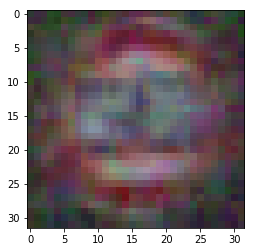

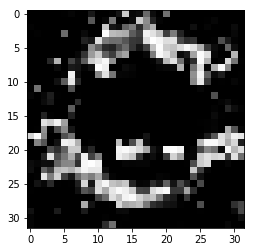

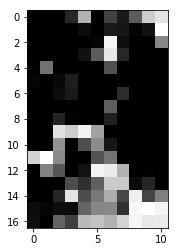

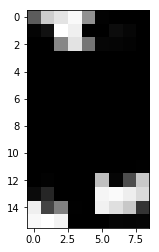

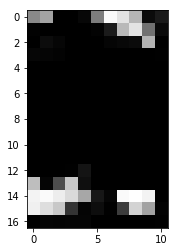

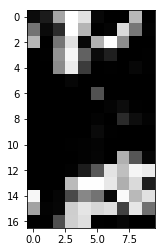

In [221]:
i = 2

x = adv[i][np.newaxis]

y = get_output([x])[0]

feed_dict = {featnet.model.get_input_at(0): x}
scores = sess.run([featnet.feat_scores, featnet.before_sigmoid], feed_dict=feed_dict)
print(scores[0])
print(scores[1])

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [170]:
featnet.predict_model(sess, X_atk)

array([[2.99791835e-04],
       [2.92344688e-04],
       [3.33332049e-04],
       [3.13676224e-04],
       [3.13584431e-04],
       [3.75793898e-04],
       [3.11974611e-04],
       [3.77126737e-04],
       [3.15073121e-04],
       [4.42629040e-04],
       [3.43336113e-04],
       [3.10498028e-04],
       [3.21633590e-04],
       [6.37727208e-04],
       [3.24364024e-04],
       [3.11531126e-04],
       [5.35708212e-04],
       [3.16743681e-04],
       [3.05902009e-04],
       [5.27854194e-04],
       [3.70730355e-04],
       [3.19875428e-04],
       [3.13822238e-04],
       [9.50824469e-04],
       [3.33077187e-04],
       [3.09027557e-04],
       [3.26943962e-04],
       [3.24366876e-04],
       [3.11090669e-04],
       [3.13633762e-04],
       [4.52888373e-04],
       [3.11053242e-04],
       [3.18093982e-04],
       [1.95974414e-03],
       [3.13058612e-04],
       [3.57047538e-04],
       [3.56180943e-04],
       [3.64173000e-04],
       [3.58045509e-04],
       [3.26355541e-04],


In [171]:
featnet.predict_model(sess, adv)

array([[1.76270401],
       [1.19161713],
       [3.58220291],
       [3.50150394],
       [3.45677352],
       [3.75224471],
       [3.88050437],
       [3.47675514],
       [3.8354125 ],
       [3.1085031 ],
       [3.7495718 ],
       [3.70696592],
       [3.80515671],
       [3.33814073],
       [2.80734015],
       [2.52227092],
       [3.76209879],
       [3.58353281],
       [3.44274354],
       [3.91459322],
       [2.71852875],
       [3.55840135],
       [2.06438351],
       [3.94040585],
       [1.86754775],
       [3.73718238],
       [1.86328447],
       [3.39254379],
       [3.76108646],
       [3.79544401],
       [3.3856144 ],
       [0.15322392],
       [2.52634692],
       [3.84758568],
       [1.91179705],
       [3.64693165],
       [2.69289541],
       [1.75182009],
       [1.0169462 ],
       [3.85857344],
       [2.09873819],
       [3.73726749],
       [3.87225962],
       [0.35886627],
       [1.44199777],
       [3.81074238],
       [3.84811068],
       [3.823

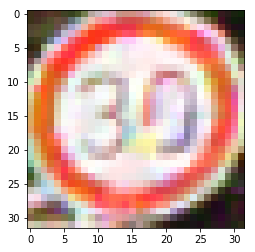

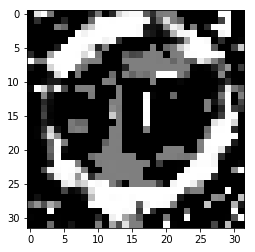

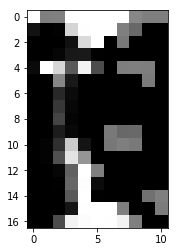

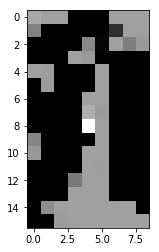

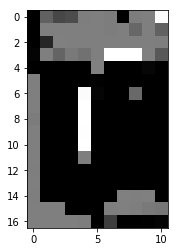

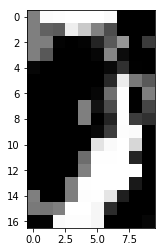

In [45]:
x = adv[1][np.newaxis]

y = get_output([x])[0]

# plt.imshow(matplotlib.colors.hsv_to_rgb(y[0]))
plt.imshow(get_stn([x])[0][0])
plt.show()
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_S)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_T)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_O)[0,:,:,0], cmap='gray')
plt.show()
plt.imshow(get_patch(y, pos_P)[0,:,:,0], cmap='gray')
plt.show()

In [19]:
featnet.predict_model(sess, adv[1][np.newaxis])

array([[3.8337636]])

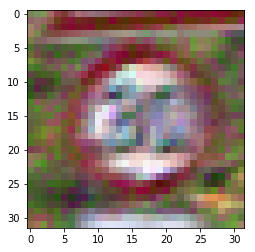

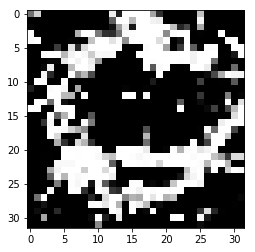

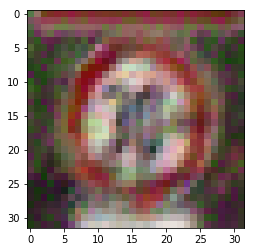

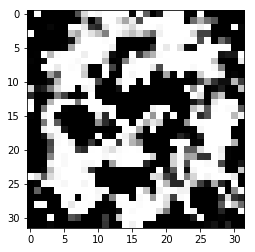

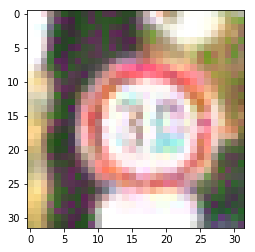

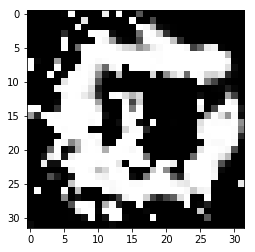

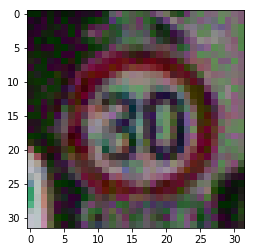

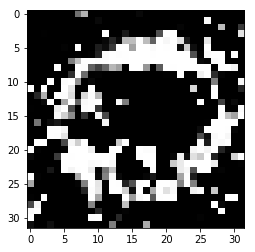

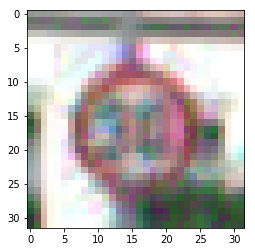

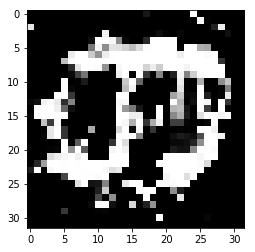

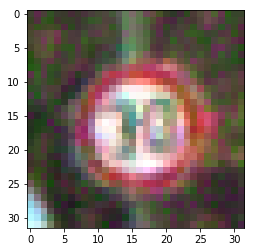

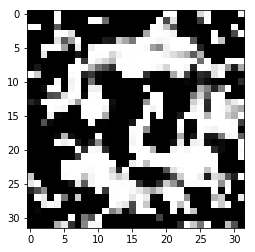

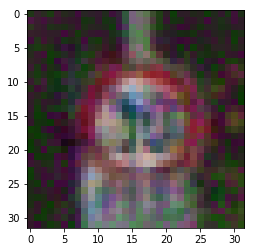

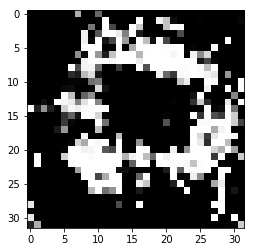

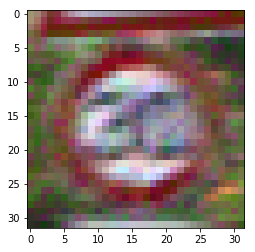

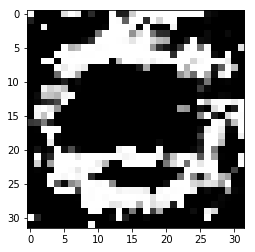

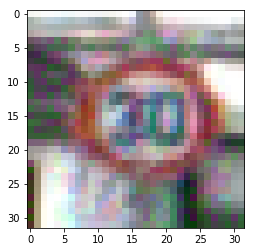

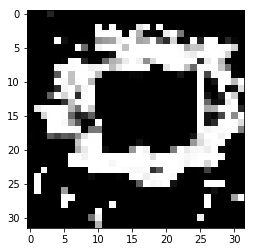

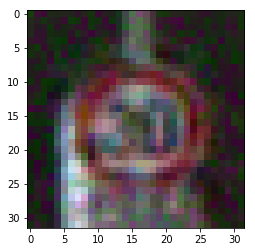

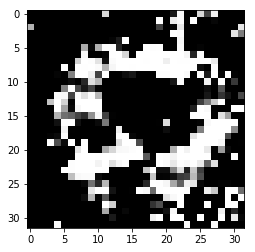

In [125]:
for i in ind[:10]:
    plt.imshow(adv[i])
    plt.show()
    y = get_output([adv[i][np.newaxis]])[0]
    plt.imshow(y[0,:,:,0], cmap='gray')
    plt.show()

In [11]:
for i in ind[:10]:
    plt.imshow(X_atk[i])
    plt.show()
    y = get_output([X_atk[i][np.newaxis]])[0]
    plt.imshow(y[0,:,:,0], cmap='gray')
    plt.show()

NameError: name 'ind' is not defined

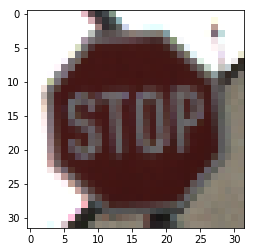

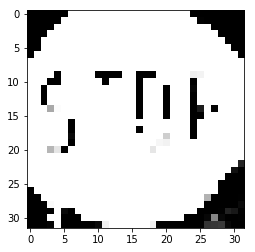

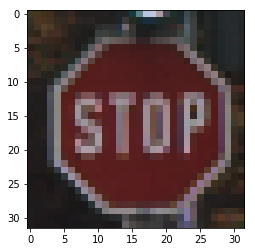

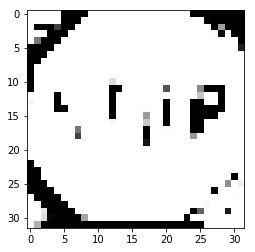

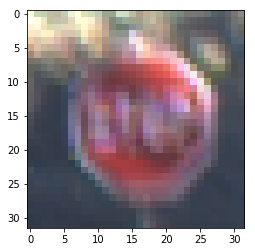

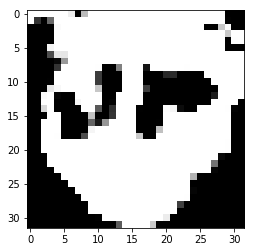

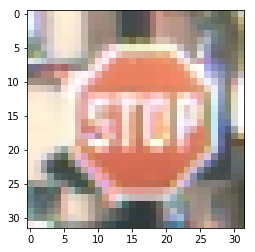

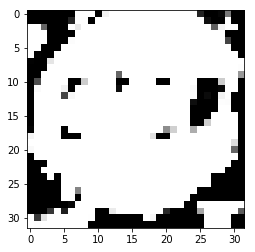

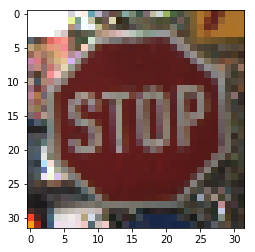

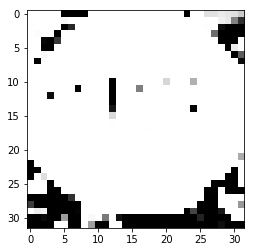

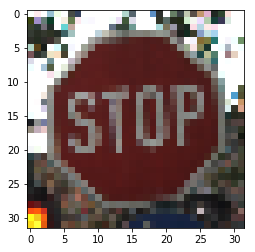

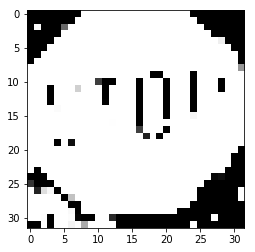

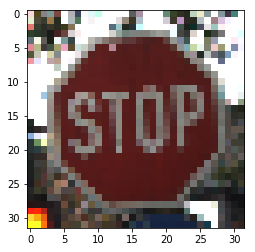

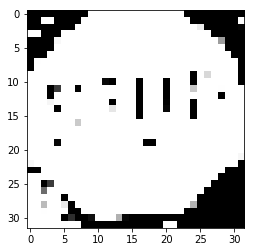

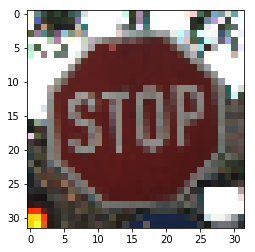

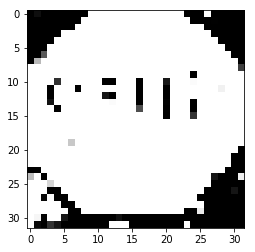

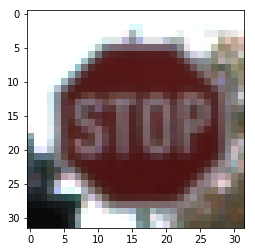

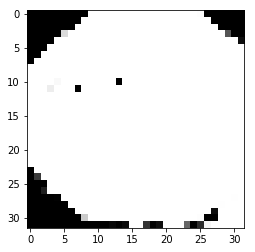

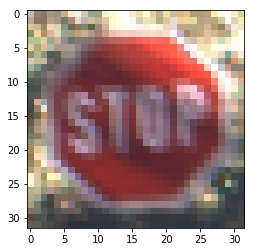

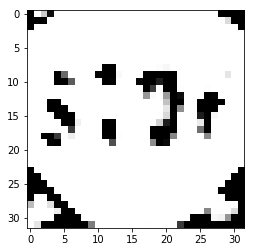

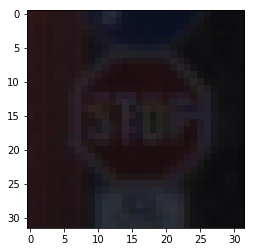

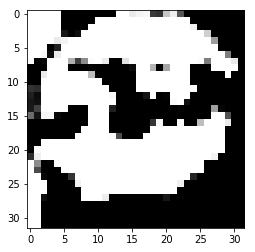

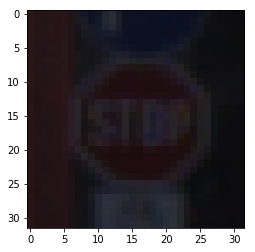

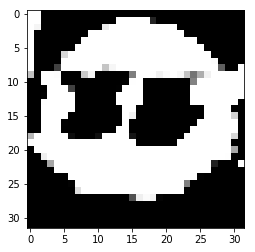

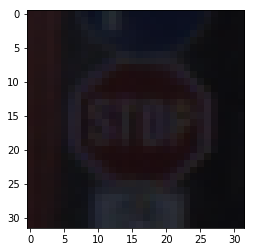

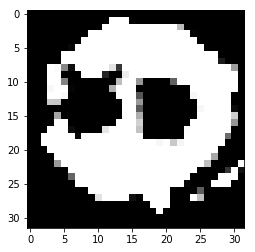

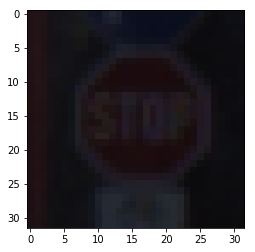

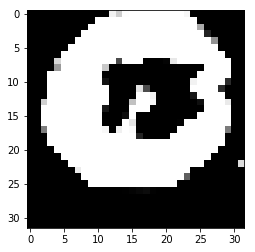

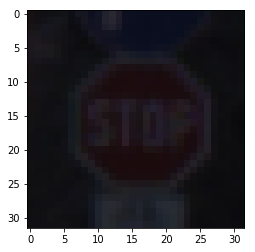

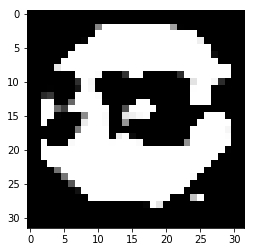

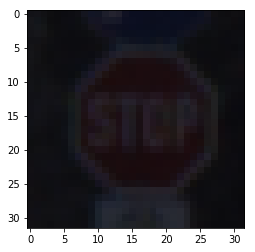

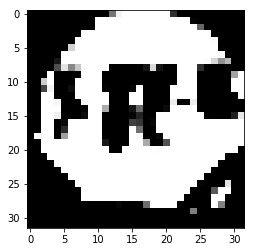

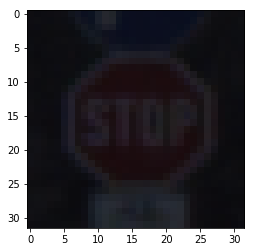

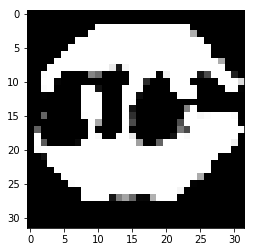

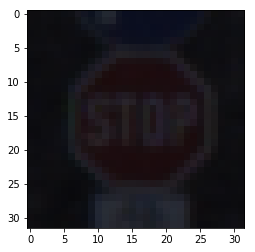

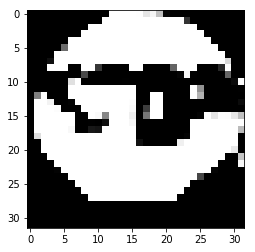

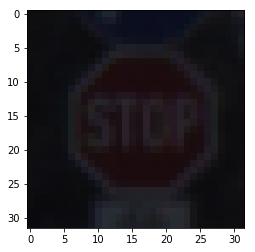

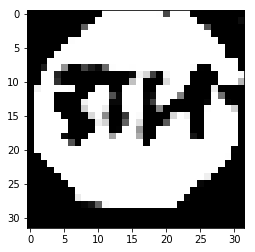

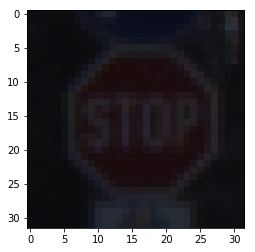

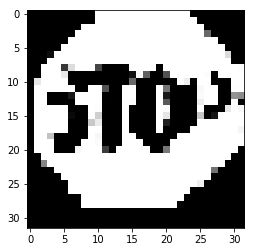

In [74]:
X = X_test[np.where(y_test == 14)[0]][:10]

for x in X:
    plt.imshow(x)
    plt.show()
    y = get_output([x[np.newaxis]])[0]
    plt.imshow(y[0,:,:,0], cmap='gray')
    plt.show()
    
X = X_train[np.where(y_train == 14)[0]][:10]

for x in X:
    plt.imshow(x)
    plt.show()
    y = get_output([x[np.newaxis]])[0]
    plt.imshow(y[0,:,:,0], cmap='gray')
    plt.show()

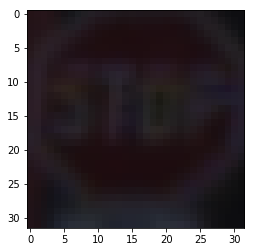

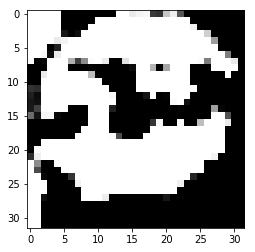

In [75]:
y = get_stn([X[0][np.newaxis]])[0]
plt.imshow(y[0,:,:])
plt.show()
y = get_output([X[0][np.newaxis]])[0]
plt.imshow(y[0,:,:,0], cmap='gray')
plt.show()

In [76]:
get_output([X[0][np.newaxis]])[0][0][14]

array([[1.0809374e-01],
       [2.5611925e-01],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [9.9999523e-01],
       [1.7881393e-07],
       [0.0000000e+00],
       [0.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.0000000e+00],
       [1.3251328e-01],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [5.9515145e-08],
       [9.6559525e-06],
       [1.6436338e-02],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00],
       [6.2176424e-01],
       [2.6144743e-02],
       [0.0000000e+00],
       [0.0000000e+00],
       [0.0000000e+00]], dtype=float32)

In [64]:
get_hsv([X[0][np.newaxis]])[0][0][14]

array([[0.89577925, 0.31076962, 0.16993386],
       [0.8978675 , 0.30725658, 0.17665973],
       [0.9412315 , 0.33467722, 0.14782754],
       [0.96537673, 0.3483196 , 0.12781021],
       [0.9622164 , 0.33863935, 0.116541  ],
       [0.9245316 , 0.2749715 , 0.11821282],
       [0.8690341 , 0.20127712, 0.12568548],
       [0.82068884, 0.13444553, 0.14630955],
       [0.8612396 , 0.12994021, 0.14121562],
       [0.9422977 , 0.1905677 , 0.12230188],
       [0.9444205 , 0.30235493, 0.12395188],
       [0.93355966, 0.33215156, 0.13681692],
       [0.89624214, 0.23838855, 0.17047822],
       [0.8424441 , 0.2048159 , 0.15015596],
       [0.7689606 , 0.25648156, 0.1223554 ],
       [0.7383922 , 0.26505387, 0.12673026],
       [0.72367376, 0.18870352, 0.13428468],
       [0.7379423 , 0.02687154, 0.14620936],
       [0.1633861 , 0.07706672, 0.13106349],
       [0.16276324, 0.16533953, 0.11529678],
       [0.13270438, 0.11299949, 0.13068509],
       [0.05575955, 0.07689591, 0.13511905],
       [0.

In [71]:
matplotlib.colors.rgb_to_hsv(get_stn([X[0][np.newaxis]])[0][0])[14]

array([[0.89577925, 0.31076962, 0.16993386],
       [0.8978675 , 0.30725658, 0.17665973],
       [0.9412315 , 0.33467722, 0.14782754],
       [0.96537673, 0.3483196 , 0.12781021],
       [0.9622164 , 0.33863935, 0.116541  ],
       [0.9245316 , 0.2749715 , 0.11821282],
       [0.8690341 , 0.20127712, 0.12568548],
       [0.8206889 , 0.13444553, 0.14630955],
       [0.8612396 , 0.12994021, 0.14121562],
       [0.9422977 , 0.1905677 , 0.12230188],
       [0.9444205 , 0.30235493, 0.12395188],
       [0.93355966, 0.33215156, 0.13681692],
       [0.89624214, 0.23838855, 0.17047822],
       [0.8424441 , 0.2048159 , 0.15015596],
       [0.76896054, 0.25648156, 0.1223554 ],
       [0.7383922 , 0.26505387, 0.12673026],
       [0.72367376, 0.18870352, 0.13428468],
       [0.7379423 , 0.02687154, 0.14620936],
       [0.16338615, 0.07706672, 0.13106349],
       [0.16276324, 0.16533953, 0.11529678],
       [0.13270435, 0.11299949, 0.13068509],
       [0.05575952, 0.07689591, 0.13511905],
       [0.

In [130]:
from feat_net import FeatNet

featnet = FeatNet("featnet_thres_v6", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres="diff",
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_thres_v6.h5",
                  load_model=False,
                  stn_weight=stn_weight)
data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
featnet.train_model(sess, data, dataaug=False, n_epoch=20, batch_size=128, thres=0.75)

============= EPOCH: 0 =============
STEP: 0 	Loss: -0.0556
STEP: 50 	Loss: -1.4483
STEP: 100 	Loss: -1.7478
STEP: 150 	Loss: -1.5592
STEP: 200 	Loss: -2.0496
STEP: 250 	Loss: -2.0067
STEP: 300 	Loss: -2.0307
STEP: 350 	Loss: -1.8918
STEP: 400 	Loss: -1.6970
STEP: 450 	Loss: -1.8766
STEP: 500 	Loss: -1.7293
Train Acc|Loss:	0.9876|-1.9055
Val Acc|Loss:	0.9170|-1.7593
============= EPOCH: 1 =============
STEP: 0 	Loss: -2.1520
STEP: 50 	Loss: -1.9537
STEP: 100 	Loss: -1.8303
STEP: 150 	Loss: -2.0149
STEP: 200 	Loss: -2.1145
STEP: 250 	Loss: -2.0716
STEP: 300 	Loss: -1.4942
STEP: 350 	Loss: -2.1689
STEP: 400 	Loss: -1.7949
STEP: 450 	Loss: -2.0362
STEP: 500 	Loss: -2.0864
Train Acc|Loss:	0.9896|-1.9218
Val Acc|Loss:	0.9172|-1.7621
============= EPOCH: 2 =============
STEP: 0 	Loss: -1.8366
STEP: 50 	Loss: -2.1427
STEP: 100 	Loss: -1.8915
STEP: 150 	Loss: -1.6190
STEP: 200 	Loss: -1.8348
STEP: 250 	Loss: -1.6825
STEP: 300 	Loss: -2.0306
STEP: 350 	Loss: -1.8059
STEP: 400 	Loss: -1.9333
STE

In [ ]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=)

## Train with HSVHardThres, attack with HSVDiffThres

In [87]:
from feat_net import FeatNet

featnet = FeatNet("featnet_thres_v5", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres="hard",
                  learning_rate=1e-4, 
                  reg=1e-3,
                  save_path="model/featnet_thres_v5.h5",
                  load_model=True,
                  stn_weight=stn_weight)
# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, dataaug=False, n_epoch=20, batch_size=128, thres=0)

============= EPOCH: 0 =============
STEP: 0 	Loss: -0.0365
STEP: 50 	Loss: -2.4969
STEP: 100 	Loss: -3.4020
STEP: 150 	Loss: -3.5448
STEP: 200 	Loss: -3.5254
STEP: 250 	Loss: -3.7685
STEP: 300 	Loss: -3.6177
STEP: 350 	Loss: -3.7899
STEP: 400 	Loss: -3.5134
STEP: 450 	Loss: -3.5643
STEP: 500 	Loss: -3.7154
Train Acc|Loss:	0.9799|-3.7286
Val Acc|Loss:	0.9781|-3.5736
============= EPOCH: 1 =============
STEP: 0 	Loss: -3.6713
STEP: 50 	Loss: -3.9210
STEP: 100 	Loss: -3.7588
STEP: 150 	Loss: -3.7068
STEP: 200 	Loss: -3.7096
STEP: 250 	Loss: -3.6985
STEP: 300 	Loss: -3.7210
STEP: 350 	Loss: -3.6542
STEP: 400 	Loss: -3.7893
STEP: 450 	Loss: -3.6282
STEP: 500 	Loss: -3.8901
Train Acc|Loss:	0.9862|-3.7651
Val Acc|Loss:	0.9545|-3.3539
============= EPOCH: 2 =============
STEP: 0 	Loss: -3.8218
STEP: 50 	Loss: -3.7853
STEP: 100 	Loss: -3.6181
STEP: 150 	Loss: -3.8863
STEP: 200 	Loss: -3.7731
STEP: 250 	Loss: -3.8147
STEP: 300 	Loss: -3.6445
STEP: 350 	Loss: -3.6795
STEP: 400 	Loss: -3.6733
STE

In [88]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=0)

(0.9771035598705502, -3.5967599748407753)

In [89]:
from feat_net import FeatNet

featnet = FeatNet("test", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres="hard",
                  learning_rate=1e-5, 
                  reg=1e-3,
                  save_path="model/test.h5",
                  load_model=True,
                  stn_weight=stn_weight)
# data = (X_train_bal, y_train_bal, X_val_bal, y_val_bal)
# featnet.train_model(sess, data, dataaug=False, n_epoch=20, batch_size=128, thres=0)

============= EPOCH: 0 =============
STEP: 0 	Loss: -0.0367
STEP: 50 	Loss: -0.8239
STEP: 100 	Loss: -1.2415
STEP: 150 	Loss: -1.3486
STEP: 200 	Loss: -1.7228
STEP: 250 	Loss: -1.9323
STEP: 300 	Loss: -2.2658
STEP: 350 	Loss: -2.1766
STEP: 400 	Loss: -2.7958
STEP: 450 	Loss: -2.7221
STEP: 500 	Loss: -3.1149
Train Acc|Loss:	0.9562|-3.0285
Val Acc|Loss:	0.9708|-2.9747
============= EPOCH: 1 =============
STEP: 0 	Loss: -3.1352
STEP: 50 	Loss: -3.0099
STEP: 100 	Loss: -3.2763
STEP: 150 	Loss: -3.1403
STEP: 200 	Loss: -3.3844
STEP: 250 	Loss: -3.1923
STEP: 300 	Loss: -3.3643
STEP: 350 	Loss: -3.3471
STEP: 400 	Loss: -3.4151
STEP: 450 	Loss: -3.4714
STEP: 500 	Loss: -3.4357
Train Acc|Loss:	0.9688|-3.4760
Val Acc|Loss:	0.9771|-3.3765
============= EPOCH: 2 =============
STEP: 0 	Loss: -3.6090
STEP: 50 	Loss: -3.4542
STEP: 100 	Loss: -3.3691
STEP: 150 	Loss: -3.4048
STEP: 200 	Loss: -3.6026
STEP: 250 	Loss: -3.5372
STEP: 300 	Loss: -3.6299
STEP: 350 	Loss: -3.5128
STEP: 400 	Loss: -3.5374
STE

In [90]:
featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=0)

(0.9713592233009709, -3.5699145661202834)

In [101]:
featnet = FeatNet("featnet_thres_v5", [32, 32, 3], [1], 
                  [pos_S, pos_T, pos_O, pos_P], 
                  hsv=True,
                  thres="hard",
                  learning_rate=1e-5, 
                  reg=1e-3,
                  save_path="model/featnet_thres_v5.h5",
                  load_model=True,
                  stn_weight=stn_weight)

featnet.eval_model(sess, (X_test_bal, y_test_bal), thres=0)

(0.9771035598705502, -3.5967599748407753)

In [102]:
# Attack on featnet + orig model

keras.backend.set_learning_phase(0)
set_log_level(logging.DEBUG)

from lib.custom_pgd import CustomPGD

pgd_params = {'eps': 0.1,
              'eps_iter': 0.01,
              'clip_min': 0.,
              'clip_max': 1.,
              'ord': np.inf, 
              'nb_iter': 50,
              'rand_init': False,
              'batch_size': n_attack,
              'y_target': y_target}
wrap_clf = KerasModelWrapper(model)
pgd = CustomPGD(wrap_clf, featnet, 0, sess=sess)
adv = pgd.generate_np(X_atk, **pgd_params)

/home/research/nn_proof/lib/custom_pgd.py:716: UserWarning: Supplied extra keyword arguments that are not used in the graph computation. They have been ignored.
  warnings.warn("Supplied extra keyword arguments that are not "
[INFO 2018-11-05 00:54:12,352 cleverhans] Constructing new graph for attack CustomPGD
/usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [103]:
y_pred = model.predict(adv)
m_suc = np.argmax(y_pred, axis=1) == 14
f_suc = featnet.predict_model(sess, adv)[:, 0] >= 0
both = np.logical_and(m_suc, f_suc)
print("Attack success on orig clf: ", np.mean(m_suc))
print("Attack success on featnet: ", np.mean(f_suc))
print("Attack success on both: ", np.mean(both))

ind = np.where(both)[0]
l2_dist = np.mean(np.sqrt(np.sum((X_atk[ind] - adv[ind])**2, (1, 2, 3))))
linf_dist = np.mean(np.max(np.abs(X_atk[ind] - adv[ind]), (1, 2, 3)))
print("Mean successful l-2 dist: ", l2_dist)
print("Mean successful l-inf dist: ", linf_dist)

Attack success on orig clf:  0.86
Attack success on featnet:  0.0
Attack success on both:  0.0
Mean successful l-2 dist:  nan
Mean successful l-inf dist:  nan


/usr/local/lib/python3.5/dist-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/usr/local/lib/python3.5/dist-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)
